# Predcition of Hospital Admission Related to Cough Cold

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to cough cold.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'cough_cold_date_'+str(i), 'cough_cold_ab_date_'+str(i), 'cough_cold_ab_type_'+str(i),
                   'incdt_cough_cold_date_'+str(i), 'admitted_cough_cold_date_'+str(i), 'sgss_gp_cov_cough_cold_date_'+str(i)]]
    
    #drop rows with no cough_cold reord
    datum = datum[datum['cough_cold_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with cough_cold_i
    datum = datum[datum['sgss_gp_cov_cough_cold_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'cough_cold_date_'+str(i): 'cough_cold_date', 'cough_cold_ab_date_'+str(i): 'cough_cold_ab_date', 
                           'cough_cold_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_cough_cold_date_'+str(i): 'incdt_cough_cold_date', 'incdt_cough_cold_type_'+str(i): 'incdt_cough_cold_type',
                           'admitted_cough_cold_date_'+str(i): 'admitted_cough_cold_date',
                           'sgss_gp_cov_cough_cold_date_'+str(i): 'sgss_gp_cov_cough_cold_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_cough_cold_admitted', 'duration_cough_cold_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [10]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_cough_cold/data_cough_cold_record_cph_cough_cold.txt", "w")
a.write("")
a.writelines(['data_cough_cold_1 #with a record, #with no record: %.0f' % (data['cough_cold_date_1'].notna().sum()), ', %.0f' % (data['cough_cold_date_1'].isna().sum()),
              '\ndata_cough_cold_2 #with a record, #with no record: %.0f' % (data['cough_cold_date_2'].notna().sum()), ', %.0f' % (data['cough_cold_date_2'].isna().sum()),
              '\ndata_cough_cold_3 #with a record, #with no record: %.0f' % (data['cough_cold_date_3'].notna().sum()), ', %.0f' % (data['cough_cold_date_3'].isna().sum()),
              '\ndata_cough_cold_4 #with a record, #with no record: %.0f' % (data['cough_cold_date_4'].notna().sum()), ', %.0f' % (data['cough_cold_date_4'].isna().sum()),
              '\ndata_cough_cold_5 #with a record, #with no record: %.0f' % (data['cough_cold_date_5'].notna().sum()), ', %.0f' % (data['cough_cold_date_5'].isna().sum()),
              '\ndata_cough_cold_6 #with a record, #with no record: %.0f' % (data['cough_cold_date_6'].notna().sum()), ', %.0f' % (data['cough_cold_date_6'].isna().sum()),
              '\ndata_cough_cold_7 #with a record, #with no record: %.0f' % (data['cough_cold_date_7'].notna().sum()), ', %.0f' % (data['cough_cold_date_7'].isna().sum()),
              '\ndata_cough_cold_8 #with a record, #with no record: %.0f' % (data['cough_cold_date_8'].notna().sum()), ', %.0f' % (data['cough_cold_date_8'].isna().sum()),
              '\ndata_cough_cold_9 #with a record, #with no record: %.0f' % (data['cough_cold_date_9'].notna().sum()), ', %.0f' % (data['cough_cold_date_9'].isna().sum()),
              '\ndata_cough_cold_10 #with a record, #with no record: %.0f' % (data['cough_cold_date_10'].notna().sum()), ', %.0f' % (data['cough_cold_date_10'].isna().sum()),
              '\ndata_cough_cold_11 #with a record, #with no record: %.0f' % (data['cough_cold_date_11'].notna().sum()), ', %.0f' % (data['cough_cold_date_11'].isna().sum()),
              '\ndata_cough_cold_12 #with a record, #with no record: %.0f' % (data['cough_cold_date_12'].notna().sum()), ', %.0f' % (data['cough_cold_date_12'].isna().sum()),
              '\ndata_cough_cold_13 #with a record, #with no record: %.0f' % (data['cough_cold_date_13'].notna().sum()), ', %.0f' % (data['cough_cold_date_13'].isna().sum()),
              '\ndata_cough_cold_14 #with a record, #with no record: %.0f' % (data['cough_cold_date_14'].notna().sum()), ', %.0f' % (data['cough_cold_date_14'].isna().sum()),
              '\ndata_cough_cold_15 #with a record, #with no record: %.0f' % (data['cough_cold_date_15'].notna().sum()), ', %.0f' % (data['cough_cold_date_15'].isna().sum()),
              '\ndata_cough_cold_16 #with a record, #with no record: %.0f' % (data['cough_cold_date_16'].notna().sum()), ', %.0f' % (data['cough_cold_date_16'].isna().sum()),
              '\ndata_cough_cold_17 #with a record, #with no record: %.0f' % (data['cough_cold_date_17'].notna().sum()), ', %.0f' % (data['cough_cold_date_17'].isna().sum()),
              '\ndata_cough_cold_18 #with a record, #with no record: %.0f' % (data['cough_cold_date_18'].notna().sum()), ', %.0f' % (data['cough_cold_date_18'].isna().sum()),
              '\ndata_cough_cold_19 #with a record, #with no record: %.0f' % (data['cough_cold_date_19'].notna().sum()), ', %.0f' % (data['cough_cold_date_19'].isna().sum()),
              '\ndata_cough_cold_20 #with a record, #with no record: %.0f' % (data['cough_cold_date_20'].notna().sum()), ', %.0f' % (data['cough_cold_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37091
1.0     36986
2.0     33072
3.0     24718
4.0     14839
6.0     12314
7.0     10012
5.0      8355
8.0      8028
9.0      5956
10.0     3286
11.0     1924
12.0     1345
13.0      821
14.0      533
15.0      351
16.0      186
17.0      104
18.0       42
19.0       20
20.0       14
22.0        2
21.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 20 cough_colds and concatenate them 
data_cough_cold_1 = proc_infec_data(data,1)
data_cough_cold_2 = proc_infec_data(data,2)
data_cough_cold_3 = proc_infec_data(data,3)
data_cough_cold_4 = proc_infec_data(data,4)
data_cough_cold_5 = proc_infec_data(data,5)
data_cough_cold_6 = proc_infec_data(data,6)
data_cough_cold_7 = proc_infec_data(data,7)
data_cough_cold_8 = proc_infec_data(data,8)
data_cough_cold_9 = proc_infec_data(data,9)
data_cough_cold_10 = proc_infec_data(data,10)
data_cough_cold_11 = proc_infec_data(data,11)
data_cough_cold_12 = proc_infec_data(data,12)
data_cough_cold_13 = proc_infec_data(data,13)
data_cough_cold_14 = proc_infec_data(data,14)
data_cough_cold_15 = proc_infec_data(data,15)
data_cough_cold_16 = proc_infec_data(data,16)
data_cough_cold_17 = proc_infec_data(data,17)
data_cough_cold_18 = proc_infec_data(data,18)
data_cough_cold_19 = proc_infec_data(data,19)
data_cough_cold_20 = proc_infec_data(data,20)

data_cough_cold = pd.concat([data_cough_cold_1, data_cough_cold_2, data_cough_cold_3, data_cough_cold_4, data_cough_cold_5, data_cough_cold_6, data_cough_cold_7, data_cough_cold_8, data_cough_cold_9, data_cough_cold_10, data_cough_cold_11, data_cough_cold_12, data_cough_cold_13, data_cough_cold_14, data_cough_cold_15, data_cough_cold_16, data_cough_cold_17, data_cough_cold_18, data_cough_cold_19, data_cough_cold_20])
data_cough_cold.reset_index(inplace=True, drop=True)
data_cough_cold.shape

(360312, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_cough_cold['cough_cold_date'] = data_cough_cold['cough_cold_date'].astype('datetime64[ns]')
data_cough_cold['admitted_cough_cold_date'] = data_cough_cold['admitted_cough_cold_date'].astype('datetime64[ns]')
data_cough_cold.died_date = data_cough_cold.died_date.astype('datetime64[ns]')
data_cough_cold.deregistered_date = data_cough_cold.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_cough_cold['date'] = data_cough_cold['cough_cold_date'] #gp_cons_cough_cold
data_cough_cold['date'] = data_cough_cold['date'].dt.strftime('%Y-%m')
print(f'min date: {data_cough_cold.date.min()}')
print(f'max date: {data_cough_cold.date.max()}')
print(f'length of data_cough_cold: {len(data_cough_cold)}')

min date: 2019-01
max date: 2022-11
length of data_cough_cold: 360312


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_cough_cold with today's date in year and month
data_cough_cold = data_cough_cold[data_cough_cold['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_cough_cold = data_cough_cold[data_cough_cold['date'] != last_1_month_date_y_m]
data_cough_cold = data_cough_cold[data_cough_cold['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of cough_cold records
data_cough_cold['season'] = np.nan
data_cough_cold['date_month'] = pd.DatetimeIndex(data_cough_cold['date']).month

conditions = [
    (data_cough_cold['date_month'] >= 3) & (data_cough_cold['date_month'] <= 5),
    (data_cough_cold['date_month'] >= 6) & (data_cough_cold['date_month'] <= 8),
    (data_cough_cold['date_month'] >= 9) & (data_cough_cold['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_cough_cold['season'] = np.select(conditions, choices, default='winter')

print(data_cough_cold['season'].value_counts())
print(f'\nmin date: {data_cough_cold.date.min()}')
print(f'max date: {data_cough_cold.date.max()}')
print(f'length: {len(data_cough_cold)}')

spring    93832
summer    93300
winter    83844
autumn    69288
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 340264


In [24]:
# data_cough_cold = data_cough_cold[data_cough_cold['date'] <= '2019-12']
# data_cough_cold = data_cough_cold[(data_cough_cold['date'] >= '2020-03') & (data_cough_cold['date']<= '2021-03')]
# data_cough_cold = data_cough_cold[data_cough_cold['date'] >= '2021-04']
# print(f'min date: {data_cough_cold.date.min()}')
# print(f'max date: {data_cough_cold.date.max()}')

In [25]:
#add period variable
data_cough_cold.loc[(data_cough_cold['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_cough_cold.loc[((data_cough_cold['date'] >= '2020-01') & (data_cough_cold['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_cough_cold.loc[(data_cough_cold['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [26]:
#scenario 1
#not hosped (nothing happened)
#data_cough_cold = data_cough_cold[data_cough_cold['admitted_cough_cold_date'].notnull()]
data_cough_cold.loc[data_cough_cold['admitted_cough_cold_date'].isnull(), 'event_cough_cold_admitted'] = 0
data_cough_cold['event_cough_cold_admitted'].value_counts()

0.0    238255
Name: event_cough_cold_admitted, dtype: int64

In [27]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_cough_cold['delta_cough_cold_admitted'] = (data_cough_cold['admitted_cough_cold_date'] - data_cough_cold['cough_cold_date']).dt.days
data_cough_cold['delta_cough_cold_admitted'] = (data_cough_cold['admitted_cough_cold_date'] - data_cough_cold['cough_cold_date']).dt.days #gp_cons_cough_cold
data_cough_cold.loc[((data_cough_cold['delta_cough_cold_admitted'] >= 0) & (data_cough_cold['delta_cough_cold_admitted'] <= 30)), 'event_cough_cold_admitted'] = 1
# data_cough_cold['event_cough_cold_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before cough_cold consultation, i.e. negative value for delta_cough_cold_admitted
data_cough_cold = data_cough_cold[~(data_cough_cold['delta_cough_cold_admitted'] < 0)]
data_cough_cold['delta_cough_cold_admitted'].value_counts()

23.0      94
91.0      92
150.0     89
41.0      89
60.0      87
          ..
1367.0     1
1375.0     1
1324.0     1
1393.0     1
1384.0     1
Name: delta_cough_cold_admitted, Length: 1392, dtype: int64

In [28]:
#scenario 3
#censor died patients
data_cough_cold['delta_admitted_died'] = (data_cough_cold['died_date'] - data_cough_cold['admitted_cough_cold_date']).dt.days
data_cough_cold.loc[data_cough_cold['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_cough_cold.loc[data_cough_cold['delta_admitted_died'] >= 0, 'event_cough_cold_admitted'] = 0
data_cough_cold.loc[((data_cough_cold['delta_admitted_died'] >= 0) & (data_cough_cold['delta_admitted_died'] <= 30)), 'event_cough_cold_admitted'] = 0
# data_cough_cold['event_cough_cold_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_cough_cold['delta_admitted_deregistered'] = (data_cough_cold['deregistered_date'] - data_cough_cold['admitted_cough_cold_date']).dt.days
data_cough_cold.loc[data_cough_cold['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_cough_cold.loc[data_cough_cold['delta_admitted_deregistered'] >= 0, 'event_cough_cold_admitted'] = 0
data_cough_cold.loc[((data_cough_cold['delta_admitted_deregistered'] > 0) & (data_cough_cold['delta_admitted_deregistered'] <= 30)), 'event_cough_cold_admitted'] = 0
# data_cough_cold['event_cough_cold_admitted'].value_counts()

#agg scenario 3s
data_cough_cold['delta_admitted_died_deregistered'] = data_cough_cold['delta_admitted_deregistered'].combine_first(data_cough_cold['delta_admitted_died'])
data_cough_cold.loc[data_cough_cold['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_cough_cold['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

286849

In [29]:
#scenario 1
#any other patients (nothing happened)
data_cough_cold['event_cough_cold_admitted'] = data_cough_cold['event_cough_cold_admitted'].replace(np.NaN, 0)
data_cough_cold['event_cough_cold_admitted'].value_counts()

0.0    289918
1.0      2182
Name: event_cough_cold_admitted, dtype: int64

In [30]:
#assign values for duration column
data_cough_cold['duration_cough_cold_admitted'] = data_cough_cold['delta_cough_cold_admitted'].combine_first(data_cough_cold['delta_admitted_died_deregistered'])
data_cough_cold['duration_cough_cold_admitted'] = data_cough_cold['duration_cough_cold_admitted'].replace(np.NaN, 30)
data_cough_cold.loc[(data_cough_cold['duration_cough_cold_admitted'] > 30), 'duration_cough_cold_admitted'] = 30
data_cough_cold['duration_cough_cold_admitted'].value_counts()

30.0    289987
23.0        94
17.0        83
24.0        83
16.0        80
0.0         76
21.0        76
12.0        75
20.0        75
11.0        75
19.0        73
4.0         72
1.0         72
9.0         71
10.0        71
5.0         71
13.0        70
27.0        70
26.0        68
14.0        68
29.0        67
3.0         67
25.0        67
7.0         66
2.0         65
8.0         64
18.0        64
15.0        62
22.0        61
28.0        58
6.0         49
Name: duration_cough_cold_admitted, dtype: int64

In [31]:
# give value 1 to event_cough_cold_admitted if duration_cough_cold_admitted is greater or equal to 0 and less than 30
data_cough_cold.loc[((data_cough_cold['duration_cough_cold_admitted'] >= 0) & (data_cough_cold['duration_cough_cold_admitted'] < 30)), 'event_cough_cold_admitted'] = 1
data_cough_cold['event_cough_cold_admitted'].value_counts()

0.0    289915
1.0      2185
Name: event_cough_cold_admitted, dtype: int64

In [32]:
#drop any rows with value 0 in duration column
data_cough_cold = data_cough_cold[~(data_cough_cold['duration_cough_cold_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_cough_cold.loc[((data_cough_cold['delta_cough_cold_admitted'] > 0) & (data_cough_cold['delta_cough_cold_admitted'] < 30)), 'event_cough_cold_admitted'] = 1

In [33]:
# data_cough_cold[data_cough_cold['duration_cough_cold_admitted']==0][['delta_cough_cold_admitted', 'cough_cold_date', 'gp_cons_cough_cold', 'admitted_cough_cold_date', 'delta_cough_cold_admitted', 'delta_admitted_died_deregistered', 'event_cough_cold_admitted', 'duration_cough_cold_admitted']]
# data_cough_cold.loc[151:200, ['event_cough_cold_admitted', 'duration_cough_cold_admitted']]
# data_cough_cold.loc[201:250, ['event_cough_cold_admitted', 'duration_cough_cold_admitted']].sort_values(by=['duration_cough_cold_admitted'])
data_cough_cold[['event_cough_cold_admitted', 'duration_cough_cold_admitted']].sort_values(by=['duration_cough_cold_admitted'])

,event_cough_cold_admitted,duration_cough_cold_admitted
236046,1.0,1.0
295082,1.0,1.0
18809,1.0,1.0
37179,1.0,1.0
17328,1.0,1.0
...,...,...
120734,0.0,30.0
120733,0.0,30.0
120732,0.0,30.0
120740,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [34]:
# prep before plot
data_cough_cold['age'][data_cough_cold['age'] < 0] = np.nan
data_cough_cold = data_cough_cold[data_cough_cold['age_cat'] != '0-4']
data_cough_cold = data_cough_cold[data_cough_cold['age_cat'] != '5-14']
# drop anybody with age less than 18
data_cough_cold = data_cough_cold[~(data_cough_cold['age'] < 18)]  
print(f'Min age: {data_cough_cold.age.min()}')

## remove died cases
#data_cough_cold.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_cough_cold['bmi'][data_cough_cold['bmi'] < 10] = 0
# replace 0s with nans
data_cough_cold['bmi'] = data_cough_cold['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_cough_cold['antibacterial_brit'][data_cough_cold['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [35]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_cough_cold = data_cough_cold.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_cough_cold = data_cough_cold.replace({"smoking_status": dict_smoking})

In [36]:
if ('region' in data_cough_cold.columns) and (data_cough_cold['region'].isnull().sum() > 0):
    # drop region value missing
    # data_cough_cold['region_imp'] = data_cough_cold['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_cough_cold.region.isnull().sum()}')
    data_cough_cold = data_cough_cold[data_cough_cold['region'].notna()]

print(f'Cound of missing values in variable region: {data_cough_cold.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_cough_cold.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      35677
Yorkshire and The Humber    17880
South East                  17842
North East                  17744
West Midlands               17691
East                        17648
East Midlands               17589
North West                  17471
South West                  17287
Name: region, dtype: int64


In [37]:
if ('antibacterial_brit' in data_cough_cold.columns) and (data_cough_cold['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_cough_cold.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_cough_cold.antibacterial_brit.mean():.3f}')
    data_cough_cold['antibacterial_brit'] = data_cough_cold['antibacterial_brit'].fillna(0)
    # data_cough_cold['antibacterial_brit'] = data_cough_cold['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_cough_cold.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_cough_cold.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 4
Mean of antibacterial_brit values before changing NAN to zeros: 1.244

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.243


In [38]:
if ('ethnicity' in data_cough_cold.columns) and (data_cough_cold['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_cough_cold.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_cough_cold.ethnicity.value_counts()}')
    # data_cough_cold['ethnicity'] = data_cough_cold['ethnicity'].astype(str)
    data_cough_cold['ethnicity'] = data_cough_cold['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_cough_cold.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_cough_cold.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 44039
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    106283
5.0     13364
3.0     13143
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    106283
0.0     44039
5.0     13364
3.0     13143
Name: ethnicity, dtype: int64


In [39]:
if ('smoking_status' in data_cough_cold.columns) and (data_cough_cold['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_cough_cold.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_cough_cold.smoking_status.value_counts()}')
    # data_cough_cold['smoking_status'] = data_cough_cold['smoking_status'].astype(str)
    data_cough_cold['smoking_status'] = data_cough_cold['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_cough_cold.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_cough_cold.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 73601
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    69357
3.0    22930
2.0    10941
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    73601
1.0    69357
3.0    22930
2.0    10941
Name: smoking_status, dtype: int64


In [40]:
if ('imd' in data_cough_cold.columns) and (data_cough_cold['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_cough_cold.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_cough_cold.imd.value_counts()}')
    # data_cough_cold['imd'] = data_cough_cold['imd'].astype(str)
    data_cough_cold['imd'] = data_cough_cold['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_cough_cold.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_cough_cold.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
3    34192
2    33721
4    33712
5    33591
1    32828
0     8785
Name: imd, dtype: int64


In [41]:
data_cough_cold['bmi_cat'] = 5
col_bmi_cat = data_cough_cold.columns.get_loc('bmi_cat')

col_sex = data_cough_cold.columns.get_loc('sex')
col_age = data_cough_cold.columns.get_loc('age')
col_bmi = data_cough_cold.columns.get_loc('bmi')

for idx, x in enumerate(data_cough_cold['bmi_cat']):
    if data_cough_cold.iat[idx, col_bmi] >= 30:
        data_cough_cold.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_cough_cold.iat[idx, col_bmi] >= 25) and (data_cough_cold.iat[idx, col_bmi] < 30):
        data_cough_cold.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_cough_cold.iat[idx, col_bmi] >= 18.5) and (data_cough_cold.iat[idx, col_bmi] < 25):
        data_cough_cold.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_cough_cold.iat[idx, col_bmi] < 18.5:
        data_cough_cold.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_cough_cold['bmi_cat'].value_counts()

1    91518
5    45085
2    20094
3    14526
4     5606
Name: bmi_cat, dtype: int64

In [42]:
if ('bmi_cat' in data_cough_cold.columns) and (data_cough_cold['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_cough_cold.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_cough_cold.bmi_cat.value_counts()}')
    # data_cough_cold['bmi_cat'] = data_cough_cold['bmi_cat'].astype(str)
    data_cough_cold['bmi_cat'] = data_cough_cold['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_cough_cold.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_cough_cold.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    91518
5    45085
2    20094
3    14526
4     5606
Name: bmi_cat, dtype: int64


In [43]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_cough_cold.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_cough_cold['ab_type_cat'] = np.where(data_cough_cold['ab_type'].isin(ab_series[mask].index),'other',data_cough_cold['ab_type'])

#assign no to non ab users
data_cough_cold.loc[data_cough_cold['cough_cold_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_cough_cold['ab_type_cat'] = data_cough_cold['ab_type_cat'].fillna(0)
data_cough_cold['ab_type_cat'].value_counts()

no             159175
0               14121
other            2086
Amoxicillin      1086
Doxycycline       361
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [44]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [45]:
# reoplace values of dictionaries with existing ones
data_cough_cold = data_cough_cold.replace({"sex": dict_sex})
data_cough_cold = data_cough_cold.replace({"ethnicity": dict_ethnicity})
data_cough_cold = data_cough_cold.replace({"smoking_status": dict_smoking})
data_cough_cold = data_cough_cold.replace({"imd": dict_imd})
data_cough_cold = data_cough_cold.replace({"bmi_cat": dict_bmi})
data_cough_cold = data_cough_cold.replace({"flu_vaccine": dict_flu})
data_cough_cold = data_cough_cold.replace({"region": dict_region})
data_cough_cold = data_cough_cold.replace({"age_cat": dict_age})
data_cough_cold = data_cough_cold.replace({"ab_type_cat": dict_ab_type})
data_cough_cold['ab_type_cat'].value_counts()

no             159175
other           16207
Amoxicillin      1086
Doxycycline       361
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [46]:
# categorising
data_cough_cold['CCI_cat'] = pd.cut(data_cough_cold['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_cough_cold['CCI_cat'].value_counts()

low          62218
medium       34896
very_low     32694
very_high    28699
high         18322
Name: CCI_cat, dtype: int64

In [47]:
# assign max value to outliers (beyond 95 percentile)
data_cough_cold['antibacterial_brit'].clip(0, data_cough_cold['antibacterial_brit'].quantile(0.95), inplace=True)
data_cough_cold['antibacterial_brit'].max()

data_cough_cold['antibacterial_brit_cat'] = pd.cut(data_cough_cold['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_cough_cold['antibacterial_brit_cat'].value_counts()

low       102940
high       43979
medium     29910
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

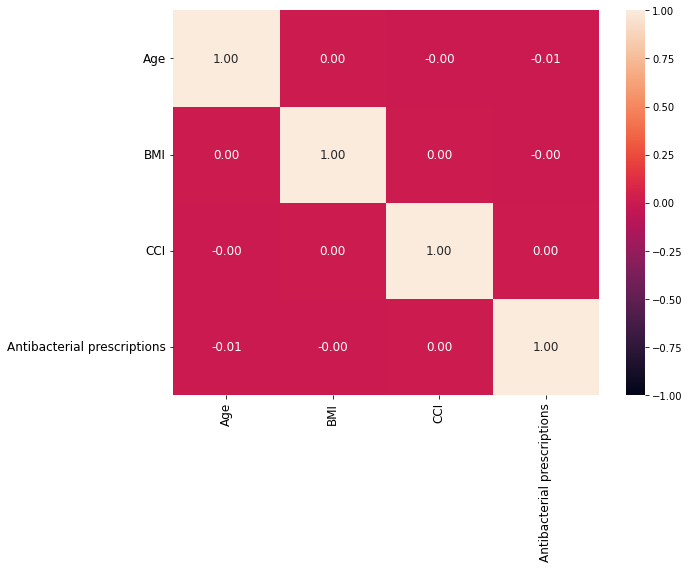

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_cough_cold[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough_cold/corr_cough_cold.jpg')
plt.show()

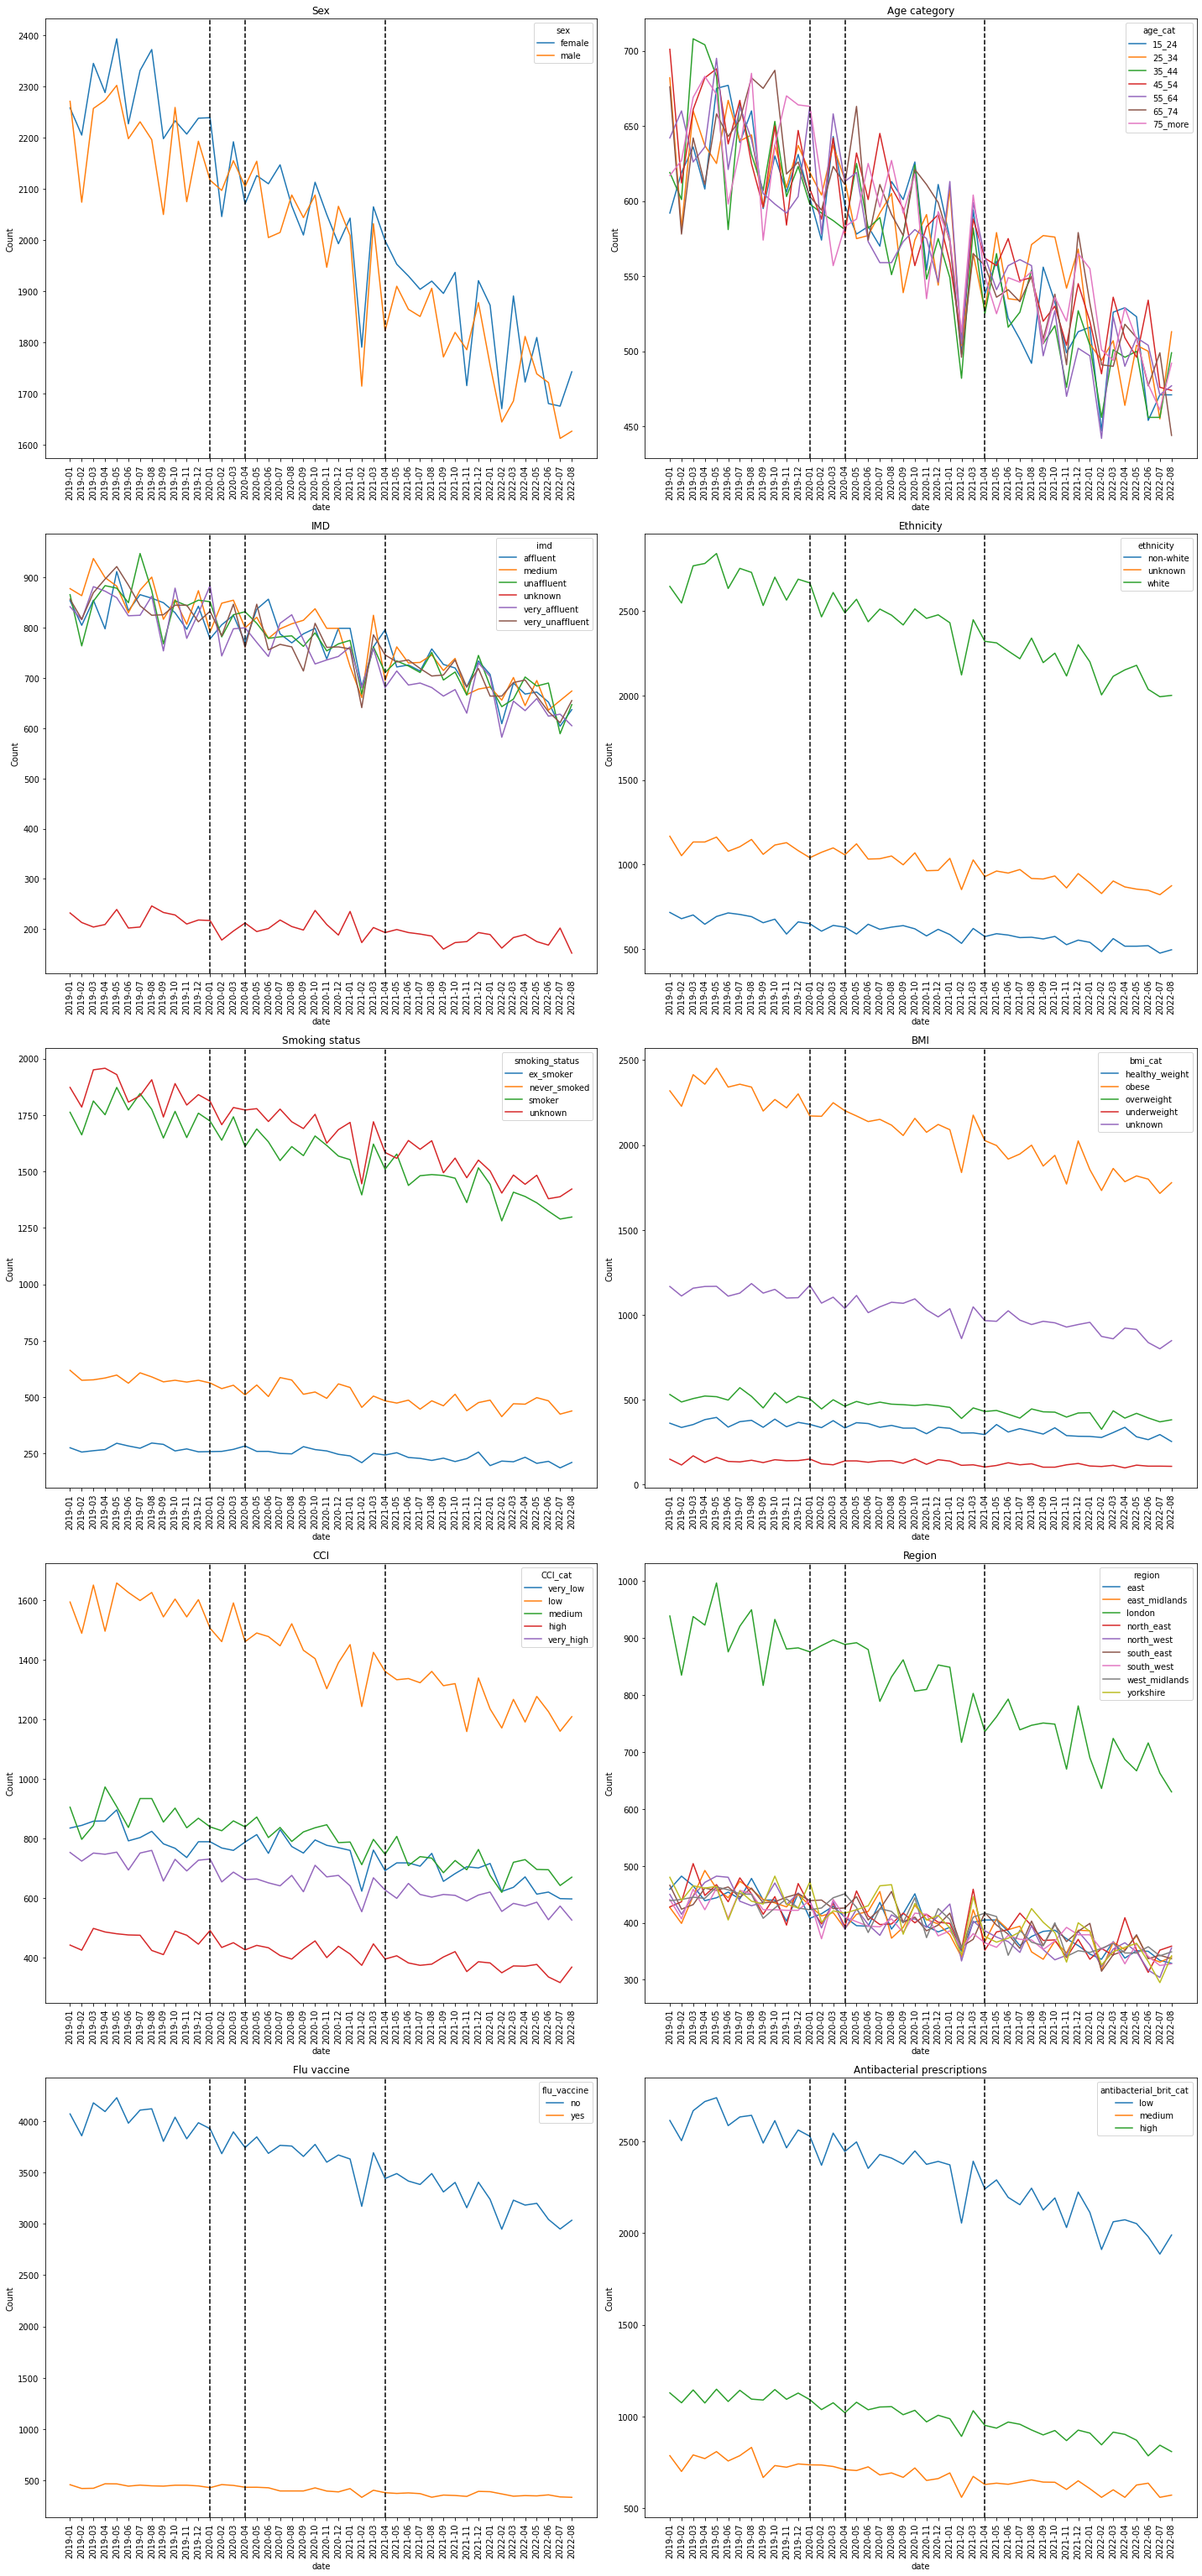

In [49]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_cough_cold, 'sex', 'Sex', axes[0,0])
create_lineplot(data_cough_cold, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_cough_cold, 'imd', 'IMD', axes[1,0])
create_lineplot(data_cough_cold, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_cough_cold, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_cough_cold, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_cough_cold, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_cough_cold, 'region', 'Region', axes[3,1])
create_lineplot(data_cough_cold, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_cough_cold, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of cough_cold patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough_cold/risk_factors_cat_cough_cold.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of cough_cold to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [50]:
data_cough_cold = data_cough_cold[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'cough_cold_ab_date', 'ab_type_cat', 'incdt_cough_cold_date', 'date', 'period',
                       'event_cough_cold_admitted', 'duration_cough_cold_admitted'
                        ]]

data_cough_cold.shape

(176829, 18)

In [51]:
#incident and prevalent infection 
data_cough_cold_incdt = data_cough_cold[data_cough_cold['incdt_cough_cold_date'] == 0]
data_cough_cold_prevl = data_cough_cold[data_cough_cold['incdt_cough_cold_date'] == 1]
#switch variable cough_cold_ab_date into a binary variable
data_cough_cold_incdt[['cough_cold_ab_date']] = data_cough_cold_incdt[['cough_cold_ab_date']].where(data_cough_cold_incdt[['cough_cold_ab_date']].isnull(), 1).fillna(0).astype(int)
data_cough_cold_prevl[['cough_cold_ab_date']] = data_cough_cold_prevl[['cough_cold_ab_date']].where(data_cough_cold_prevl[['cough_cold_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_cough_cold_incdt_males = data_cough_cold_incdt[data_cough_cold_incdt['sex'] == 'male']
data_cough_cold_incdt_females = data_cough_cold_incdt[data_cough_cold_incdt['sex'] == 'female']
data_cough_cold_prevl_males = data_cough_cold_prevl[data_cough_cold_prevl['sex'] == 'male']
data_cough_cold_prevl_females = data_cough_cold_prevl[data_cough_cold_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_cough_cold_incdt_15_24 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '15_24']
data_cough_cold_incdt_25_34 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '25_34']
data_cough_cold_incdt_35_44 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '35_44']
data_cough_cold_incdt_45_54 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '45_54']
data_cough_cold_incdt_55_64 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '55_64']
data_cough_cold_incdt_65_74 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '65_74']
data_cough_cold_incdt_75_more = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '75_more']
data_cough_cold_prevl_15_24 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '15_24']
data_cough_cold_prevl_25_34 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '25_34']
data_cough_cold_prevl_35_44 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '35_44']
data_cough_cold_prevl_45_54 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '45_54']
data_cough_cold_prevl_55_64 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '55_64']
data_cough_cold_prevl_65_74 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '65_74']
data_cough_cold_prevl_75_more = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '75_more']

data_cough_cold_incdt_prepandemic = data_cough_cold_incdt[data_cough_cold_incdt['date'] <= '2019-12']
data_cough_cold_incdt_during_pandemic = data_cough_cold_incdt[(data_cough_cold_incdt['date'] >= '2020-03') & (data_cough_cold_incdt['date']<= '2021-03')]
data_cough_cold_incdt_post_2nd_lockdown = data_cough_cold_incdt[data_cough_cold_incdt['date'] <= '2021-04']
data_cough_cold_prevl_prepandemic = data_cough_cold_prevl[data_cough_cold_prevl['date'] <= '2019-12']
data_cough_cold_prevl_during_pandemic = data_cough_cold_prevl[(data_cough_cold_prevl['date'] >= '2020-03') & (data_cough_cold_prevl['date']<= '2021-03')]
data_cough_cold_prevl_post_2nd_lockdown = data_cough_cold_prevl[data_cough_cold_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_cough_cold_incdt_abtype_0 = data_cough_cold_incdt[data_cough_cold_incdt['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[0]]
# data_cough_cold_incdt_abtype_1 = data_cough_cold_incdt[data_cough_cold_incdt['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[1]]
# data_cough_cold_incdt_abtype_2 = data_cough_cold_incdt[data_cough_cold_incdt['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[2]]
# data_cough_cold_incdt_abtype_3 = data_cough_cold_incdt[data_cough_cold_incdt['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[3]]
# data_cough_cold_prevl_abtype_0 = data_cough_cold_prevl[data_cough_cold_prevl['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[0]]
# data_cough_cold_prevl_abtype_1 = data_cough_cold_prevl[data_cough_cold_prevl['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[1]]
# data_cough_cold_prevl_abtype_2 = data_cough_cold_prevl[data_cough_cold_prevl['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[2]]
# data_cough_cold_prevl_abtype_3 = data_cough_cold_prevl[data_cough_cold_prevl['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_cough_cold_incdt_abs = data_cough_cold_incdt[data_cough_cold_incdt['cough_cold_ab_date'] == 1]
# data_cough_cold_prevl_abs = data_cough_cold_prevl[data_cough_cold_prevl['cough_cold_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_cough_cold_no_abs_incdt = data_cough_cold[data_cough_cold['cough_cold_ab_date'].isnull()] #gp_cons_cough_cold_ab
data_cough_cold_no_abs_incdt = data_cough_cold_no_abs_incdt[data_cough_cold_no_abs_incdt['incdt_cough_cold_date'] == 0]

# with antibiotics and incident hospital admission
data_cough_cold_abs_incdt = data_cough_cold[data_cough_cold['cough_cold_ab_date'].notnull()]
data_cough_cold_abs_incdt = data_cough_cold_abs_incdt[data_cough_cold_abs_incdt['incdt_cough_cold_date'] == 0]

# no antibiotics and prevalent hospital admission
data_cough_cold_no_abs_prevl = data_cough_cold[data_cough_cold['cough_cold_ab_date'].isnull()]
data_cough_cold_no_abs_prevl = data_cough_cold_no_abs_prevl[data_cough_cold_no_abs_prevl['incdt_cough_cold_date'] == 1]

# with antibiotics and prevalent hospital admission
data_cough_cold_abs_prevl = data_cough_cold[data_cough_cold['cough_cold_ab_date'].notnull()]
data_cough_cold_abs_prevl = data_cough_cold_abs_prevl[data_cough_cold_abs_prevl['incdt_cough_cold_date'] == 1]

print(f'shape of data_cough_cold_incdt: {data_cough_cold_incdt.shape}')
print(f'shape of data_cough_cold_prevl: {data_cough_cold_prevl.shape}')
print(f'shape of data_cough_cold_no_abs_incdt: {data_cough_cold_no_abs_incdt.shape}')
print(f'shape of data_cough_cold_abs_incdt: {data_cough_cold_abs_incdt.shape}')
print(f'shape of data_cough_cold_no_abs_prevl: {data_cough_cold_no_abs_prevl.shape}')
print(f'shape of data_cough_cold_abs_prevl: {data_cough_cold_abs_prevl.shape}')
print(f'\nvalue counts of data_cough_cold_no_abs_incdt: \n{data_cough_cold_no_abs_incdt.event_cough_cold_admitted.value_counts()}')
print(f'value counts of data_cough_cold_abs_incdt: \n{data_cough_cold_abs_incdt.event_cough_cold_admitted.value_counts()}')
print(f'value counts of data_cough_cold_no_abs_prevl: \n{data_cough_cold_no_abs_prevl.event_cough_cold_admitted.value_counts()}')
print(f'value counts of data_cough_cold_abs_prevl: \n{data_cough_cold_abs_prevl.event_cough_cold_admitted.value_counts()}')

shape of data_cough_cold_incdt: (159011, 18)
shape of data_cough_cold_prevl: (17818, 18)
shape of data_cough_cold_no_abs_incdt: (143152, 18)
shape of data_cough_cold_abs_incdt: (15859, 18)
shape of data_cough_cold_no_abs_prevl: (16023, 18)
shape of data_cough_cold_abs_prevl: (1795, 18)

value counts of data_cough_cold_no_abs_incdt: 
0.0    142123
1.0      1029
Name: event_cough_cold_admitted, dtype: int64
value counts of data_cough_cold_abs_incdt: 
0.0    15745
1.0      114
Name: event_cough_cold_admitted, dtype: int64
value counts of data_cough_cold_no_abs_prevl: 
0.0    15904
1.0      119
Name: event_cough_cold_admitted, dtype: int64
value counts of data_cough_cold_abs_prevl: 
0.0    1787
1.0       8
Name: event_cough_cold_admitted, dtype: int64


In [52]:
#store data for plotting hosp admission counts and percentages
%store data_cough_cold
# save data
data_cough_cold.to_csv('../output/hospitalisation_prediction_cough_cold/data_cough_cold.csv')

Stored 'data_cough_cold' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident cough_cold with no antibiotics

<lifelines.CoxPHFitter: fitted with 107364 total observations, 106559 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 107364
number of events observed = 805
   partial log-likelihood = -9302.14
         time fit was run = 2022-11-22 12:33:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.10            -0.28             0.11                 0.76                 1.12
CCI_cat[T.medium]               -0.14       0.87       0.11            -0.36             0.09                 0.70                 1.09
CCI_cat[T.high]                  0.12       1.13       0.13            -0.13             0.37                 0.87                 1.45
CCI_cat[T.very_high]            -0.06       0.94       0.12            -0.30             0.17                 0.74                 1.18
age_cat[T.25_34]                 0.10       1.10       0.13            -0.16             0.35                 0.86                 1.42
age_cat[T.35_44]                 0.05       1.05       0.13            -0.21             0.30                 0.81                 1.36
age_cat[T.45_54]                -0.13       0.88       0.14            -0.39             0.14                 0.68                 1.15
age_cat[T.55_64]                -0.00       1.00       0.13            -0.26             0.26                 0.77                 1.29
age_cat[T.65_74]                -0.08       0.92       0.13            -0.35             0.18                 0.71                 1.20
age_cat[T.75_more]              -0.01       0.99       0.13            -0.27             0.24                 0.76                 1.28
antibacterial_brit              -0.02       0.98       0.03            -0.07             0.03                 0.94                 1.03
bmi_cat[T.obese]                -0.02       0.98       0.13            -0.28             0.24                 0.76                 1.27
bmi_cat[T.overweight]           -0.15       0.86       0.17            -0.48             0.18                 0.62                 1.19
bmi_cat[T.underweight]           0.28       1.32       0.21            -0.14             0.70                 0.87                 2.00
bmi_cat[T.unknown]               0.08       1.08       0.14            -0.20             0.35                 0.82                 1.42
ethnicity[T.unknown]            -0.09       0.91       0.12            -0.32             0.14                 0.73                 1.15
ethnicity[T.white]               0.04       1.04       0.10            -0.16             0.23                 0.85                 1.26
flu_vaccine[T.yes]               0.13       1.14       0.11            -0.09             0.35                 0.92                 1.42
imd[T.medium]                    0.11       1.11       0.11            -0.11             0.32                 0.90                 1.37
imd[T.unaffluent]               -0.20       0.82       0.12            -0.43             0.03                 0.65                 1.03
imd[T.unknown]                   0.09       1.09       0.17            -0.24             0.41                 0.79                 1.51
imd[T.very_affluent]            -0.11       0.89       0.12            -0.34             0.11                 0.71                 1.12
imd[T.very_unaffluent]          -0.11       0.89       0.11            -0.34             0.11                 0.71                 1.12
region[T.east_midlands]          0.06       1.06       0.15            -0.25             0.36                 0.78                 1.43
region[T.london]                -0.02       0.98     

12790


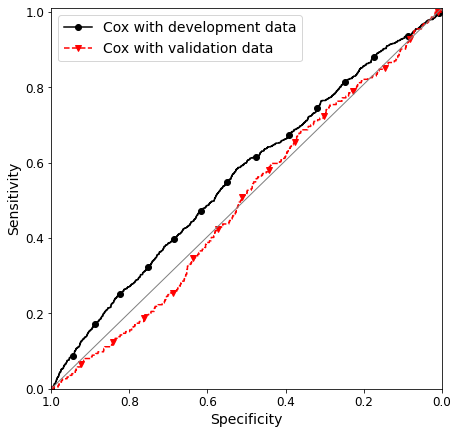

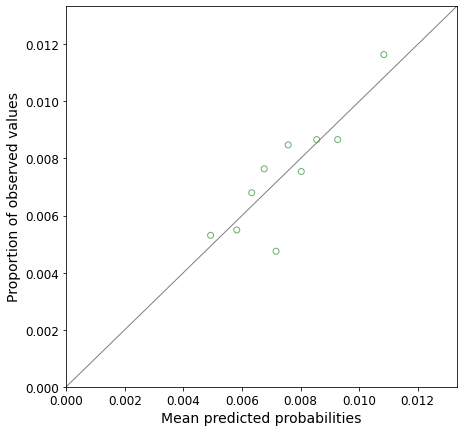

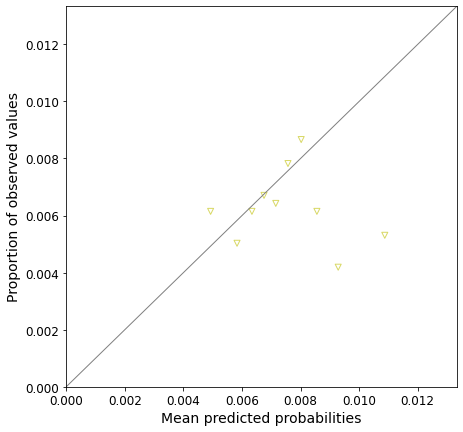

In [53]:
#data prep
data, data_cough_cold_no_abs_incdt_enc = cox_data_prep(data_cough_cold_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt)

try:
    #build cox model 
    cph_cough_cold_no_abs_incdt, data_cough_cold_no_abs_incdt_train, data_cough_cold_no_abs_incdt_test = cox_model_build('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_cold_no_abs_incdt, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_no_abs_incdt.csv', data_cough_cold_no_abs_incdt_enc, data_cough_cold_no_abs_incdt, 'sum_betas_cph_cough_cold_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_cold_no_abs_incdt, 'event_cough_cold_admitted', data_cough_cold_no_abs_incdt_train, data_cough_cold_no_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_cold_no_abs_incdt, data_cough_cold_no_abs_incdt_train, 'event_cough_cold_admitted', data_cough_cold_no_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_no_abs_incdt_train.jpg', 'calibration_cph_cough_cold_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_no_abs_incdt, 'cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt_train, data_cough_cold_no_abs_incdt_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident cough_cold with antibiotics

<lifelines.CoxPHFitter: fitted with 11894 total observations, 11818 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 11894
number of events observed = 76
   partial log-likelihood = -696.99
         time fit was run = 2022-11-22 12:34:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.31            -0.87             0.35                 0.42                 1.42
CCI_cat[T.medium]               -0.51       0.60       0.39            -1.27             0.25                 0.28                 1.29
CCI_cat[T.high]                 -0.14       0.87       0.41            -0.95             0.67                 0.39                 1.95
CCI_cat[T.very_high]            -0.13       0.88       0.37            -0.86             0.59                 0.42                 1.81
age_cat[T.25_34]                 0.08       1.08       0.46            -0.82             0.98                 0.44                 2.67
age_cat[T.35_44]                -0.01       0.99       0.47            -0.94             0.91                 0.39                 2.49
age_cat[T.45_54]                 0.61       1.84       0.41            -0.20             1.42                 0.82                 4.13
age_cat[T.55_64]                 0.49       1.64       0.43            -0.34             1.33                 0.71                 3.79
age_cat[T.65_74]                -0.43       0.65       0.53            -1.46             0.61                 0.23                 1.83
age_cat[T.75_more]               0.20       1.22       0.45            -0.68             1.08                 0.50                 2.95
antibacterial_brit              -0.08       0.93       0.08            -0.24             0.09                 0.79                 1.09
bmi_cat[T.obese]                -0.47       0.63       0.42            -1.29             0.35                 0.28                 1.42
bmi_cat[T.overweight]           -0.54       0.58       0.56            -1.63             0.55                 0.20                 1.74
bmi_cat[T.underweight]           0.00       1.00       0.69            -1.35             1.36                 0.26                 3.89
bmi_cat[T.unknown]               0.20       1.23       0.42            -0.62             1.03                 0.54                 2.81
ethnicity[T.unknown]             0.11       1.11       0.37            -0.63             0.84                 0.53                 2.31
ethnicity[T.white]              -0.03       0.97       0.34            -0.69             0.63                 0.50                 1.88
flu_vaccine[T.yes]               0.47       1.60       0.32            -0.15             1.09                 0.86                 2.96
imd[T.medium]                    0.40       1.50       0.37            -0.33             1.14                 0.72                 3.11
imd[T.unaffluent]                0.25       1.28       0.38            -0.50             1.00                 0.61                 2.71
imd[T.unknown]                  -0.44       0.64       0.76            -1.94             1.06                 0.14                 2.87
imd[T.very_affluent]             0.02       1.02       0.40            -0.76             0.81                 0.47                 2.24
imd[T.very_unaffluent]           0.15       1.16       0.39            -0.61             0.91                 0.54                 2.49
region[T.east_midlands]          0.53       1.70       0.48            -0.41             1.46                 0.67                 4.32
region[T.london]                 0.27       1.31       0.4

12776


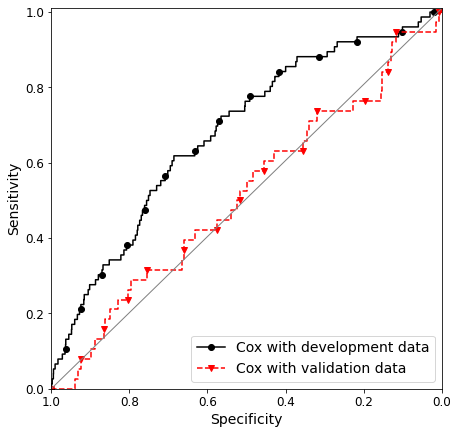

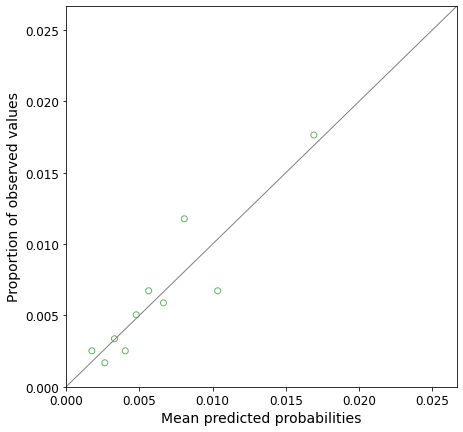

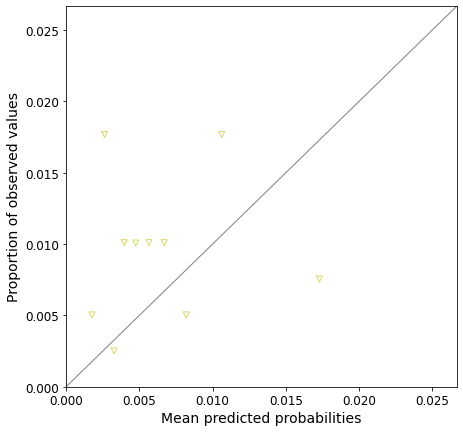

In [54]:
#data prep
data, data_cough_cold_abs_incdt_enc = cox_data_prep(data_cough_cold_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt)

try:
    #build cox model 
    cph_cough_cold_abs_incdt, data_cough_cold_abs_incdt_train, data_cough_cold_abs_incdt_test = cox_model_build('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_cold_abs_incdt, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_abs_incdt.csv', data_cough_cold_abs_incdt_enc, data_cough_cold_abs_incdt, 'sum_betas_cph_cough_cold_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_cold_abs_incdt, 'event_cough_cold_admitted', data_cough_cold_abs_incdt_train, data_cough_cold_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_cold_abs_incdt, data_cough_cold_abs_incdt_train, 'event_cough_cold_admitted', data_cough_cold_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_abs_incdt_train.jpg', 'calibration_cph_cough_cold_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_abs_incdt, 'cough_cold', 'abs_incdt', data_cough_cold_abs_incdt_train, data_cough_cold_abs_incdt_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent cough_cold with no antibiotics

<lifelines.CoxPHFitter: fitted with 12017 total observations, 11927 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 12017
number of events observed = 90
   partial log-likelihood = -828.31
         time fit was run = 2022-11-22 12:34:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.85       0.30            -0.74             0.43                 0.48                 1.53
CCI_cat[T.medium]               -0.30       0.74       0.35            -0.98             0.39                 0.37                 1.48
CCI_cat[T.high]                 -0.29       0.75       0.43            -1.12             0.55                 0.32                 1.73
CCI_cat[T.very_high]             0.13       1.13       0.33            -0.53             0.78                 0.59                 2.19
age_cat[T.25_34]                -0.64       0.53       0.39            -1.40             0.12                 0.25                 1.13
age_cat[T.35_44]                -0.78       0.46       0.40            -1.56             0.01                 0.21                 1.01
age_cat[T.45_54]                -0.25       0.78       0.34            -0.91             0.41                 0.40                 1.51
age_cat[T.55_64]                -0.21       0.81       0.34            -0.87             0.45                 0.42                 1.56
age_cat[T.65_74]                -0.58       0.56       0.38            -1.32             0.16                 0.27                 1.17
age_cat[T.75_more]              -0.91       0.40       0.42            -1.73            -0.09                 0.18                 0.92
antibacterial_brit              -0.06       0.95       0.08            -0.21             0.09                 0.81                 1.10
bmi_cat[T.obese]                 0.48       1.61       0.47            -0.44             1.40                 0.64                 4.04
bmi_cat[T.overweight]            0.58       1.79       0.53            -0.45             1.61                 0.64                 5.02
bmi_cat[T.underweight]           0.82       2.27       0.63            -0.42             2.06                 0.66                 7.88
bmi_cat[T.unknown]              -0.04       0.96       0.52            -1.06             0.97                 0.35                 2.64
ethnicity[T.unknown]             0.29       1.34       0.35            -0.39             0.97                 0.68                 2.64
ethnicity[T.white]               0.03       1.03       0.32            -0.60             0.66                 0.55                 1.93
flu_vaccine[T.yes]               0.10       1.10       0.34            -0.56             0.76                 0.57                 2.13
imd[T.medium]                   -0.10       0.90       0.34            -0.78             0.57                 0.46                 1.77
imd[T.unaffluent]                0.31       1.36       0.31            -0.30             0.92                 0.74                 2.50
imd[T.unknown]                   0.19       1.21       0.47            -0.74             1.11                 0.48                 3.04
imd[T.very_affluent]            -0.29       0.75       0.36            -0.99             0.41                 0.37                 1.51
imd[T.very_unaffluent]          -0.51       0.60       0.38            -1.26             0.24                 0.28                 1.28
region[T.east_midlands]          0.38       1.47       0.49            -0.58             1.35                 0.56                 3.86
region[T.london]                 0.41       1.50       0.4

12779


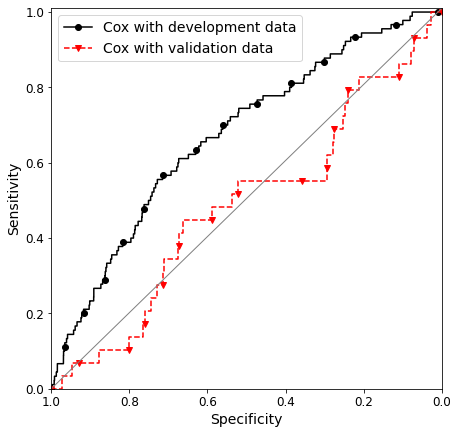

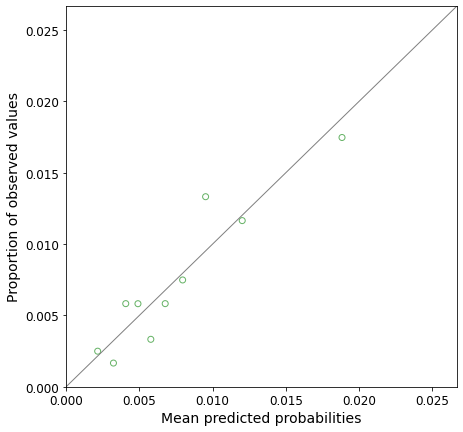

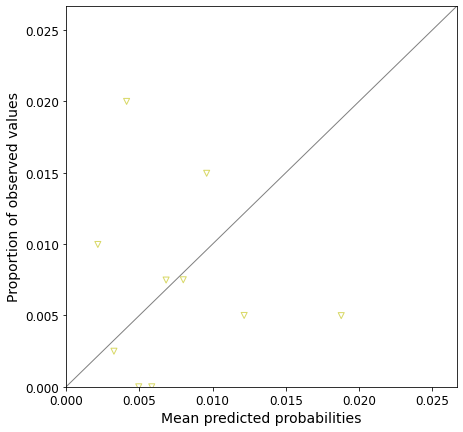

In [55]:
#data prep
data, data_cough_cold_no_abs_prevl_enc = cox_data_prep(data_cough_cold_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl)

try:
    #build cox model 
    cph_cough_cold_no_abs_prevl, data_cough_cold_no_abs_prevl_train, data_cough_cold_no_abs_prevl_test = cox_model_build('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_cold_no_abs_prevl, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_no_abs_prevl.csv', data_cough_cold_no_abs_prevl_enc, data_cough_cold_no_abs_prevl, 'sum_betas_cph_cough_cold_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_cold_no_abs_prevl, 'event_cough_cold_admitted', data_cough_cold_no_abs_prevl_train, data_cough_cold_no_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_cold_no_abs_prevl, data_cough_cold_no_abs_prevl_train, 'event_cough_cold_admitted', data_cough_cold_no_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_no_abs_prevl_train.jpg', 'calibration_cph_cough_cold_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_no_abs_prevl, 'cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl_train, data_cough_cold_no_abs_prevl_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent cough_cold with antibiotics

<lifelines.CoxPHFitter: fitted with 1346 total observations, 1342 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1346
number of events observed = 4
   partial log-likelihood = -12.29
         time fit was run = 2022-11-22 12:34:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.89       0.15       2.44            -6.66             2.89                 0.00                17.95
CCI_cat[T.medium]                0.09       1.09       3.23            -6.25             6.43                 0.00               619.51
CCI_cat[T.high]                -17.40       0.00   15861.45        -31105.27         31070.47                 0.00                  inf
CCI_cat[T.very_high]            -0.44       0.64       3.70            -7.70             6.81                 0.00               909.11
age_cat[T.25_34]               -22.77       0.00   11262.18        -22096.24         22050.70                 0.00                  inf
age_cat[T.35_44]                -0.21       0.81       3.25            -6.58             6.16                 0.00               474.87
age_cat[T.45_54]               -23.96       0.00   10833.06        -21256.36         21208.45                 0.00                  inf
age_cat[T.55_64]                -0.21       0.81       4.31            -8.65             8.23                 0.00              3733.66
age_cat[T.65_74]                -0.21       0.81       3.56            -7.19             6.76                 0.00               866.23
age_cat[T.75_more]             -21.71       0.00   12371.34        -24269.09         24225.68                 0.00                  inf
antibacterial_brit               0.33       1.39       0.77            -1.17             1.84                 0.31                 6.29
bmi_cat[T.obese]                19.85   4.18e+08   17063.99        -33424.96         33464.66                 0.00                  inf
bmi_cat[T.overweight]           23.47   1.56e+10   17063.99        -33421.34         33468.28                 0.00                  inf
bmi_cat[T.underweight]           2.97      19.54   31107.24        -60966.09         60972.04                 0.00                  inf
bmi_cat[T.unknown]              24.32   3.67e+10   17063.99        -33420.48         33469.13                 0.00                  inf
ethnicity[T.unknown]             0.21       1.23       1.55            -2.83             3.25                 0.06                25.84
ethnicity[T.white]             -23.09       0.00    7108.47        -13955.44         13909.27                 0.00                  inf
flu_vaccine[T.yes]             -18.77       0.00   15637.27        -30667.26         30629.71                 0.00                  inf
imd[T.medium]                    3.61      36.89       3.75            -3.73            10.95                 0.02             56991.75
imd[T.unaffluent]               -1.80       0.17       3.09            -7.86             4.26                 0.00                71.06
imd[T.unknown]                 -19.76       0.00   27448.30        -53817.43         53777.91                 0.00                  inf
imd[T.very_affluent]            -0.30       0.74       2.44            -5.08             4.48                 0.01                88.26
imd[T.very_unaffluent]         -18.65       0.00   11201.97        -21974.11         21936.82                 0.00                  inf
region[T.east_midlands]        -21.37       0.00   16979.16        -33299.92         33257.18                 0.00                  inf
region[T.london]                -3.20       0.04       3.01    

13079


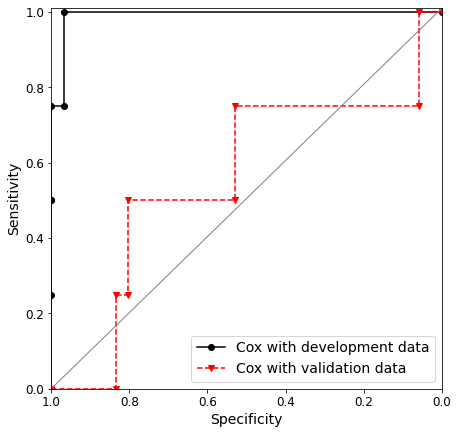

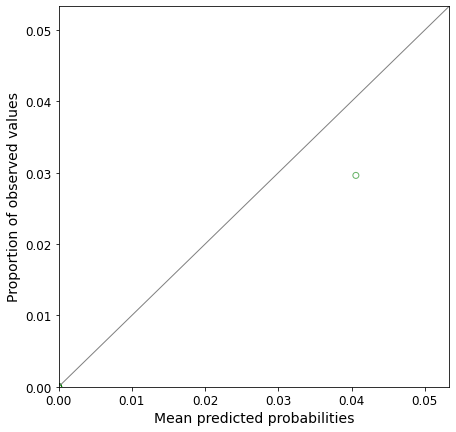

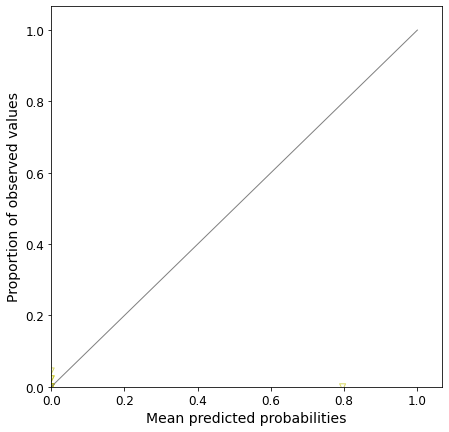

In [56]:
#data prep
data, data_cough_cold_abs_prevl_enc = cox_data_prep(data_cough_cold_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl)

try:
    #build cox model 
    cph_cough_cold_abs_prevl, data_cough_cold_abs_prevl_train, data_cough_cold_abs_prevl_test = cox_model_build('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_cold_abs_prevl, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_abs_prevl.csv', data_cough_cold_abs_prevl_enc, data_cough_cold_abs_prevl, 'sum_betas_cph_cough_cold_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_cold_abs_prevl, 'event_cough_cold_admitted', data_cough_cold_abs_prevl_train, data_cough_cold_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_cold_abs_prevl, data_cough_cold_abs_prevl_train, 'event_cough_cold_admitted', data_cough_cold_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_abs_prevl_train.jpg', 'calibration_cph_cough_cold_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_abs_prevl, 'cough_cold', 'abs_prevl', data_cough_cold_abs_prevl_train, data_cough_cold_abs_prevl_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident cough_cold

In [57]:
#data prep
data, data_cough_cold_incdt_enc = cox_data_prep(data_cough_cold_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary tables from preped data
make_summary_table('cough_cold', 'incdt', data_cough_cold_incdt_enc)
make_summary_table_hosped('cough_cold', 'incdt', data_cough_cold_incdt)

try:
    cph_cough_cold_incdt, data_cough_cold_incdt_train, data_cough_cold_incdt_test = cox_model_abs_build('cough_cold', 'incdt', data_cough_cold_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt, 'cough_cold', 'incdt', data_cough_cold_incdt_train, data_cough_cold_incdt_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119258 total observations, 118411 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 119258
number of events observed = 847
   partial log-likelihood = -9881.69
         time fit was run = 2022-11-22 12:34:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.10            -0.30             0.08                 0.74                 1.08
CCI_cat[T.medium]               -0.16       0.85       0.11            -0.38             0.06                 0.69                 1.06
CCI_cat[T.high]                  0.01       1.01       0.13            -0.24             0.26                 0.79                 1.30
CCI_cat[T.very_high]            -0.17       0.84       0.12            -0.40             0.06                 0.67                 1.06
age_cat[T.25_34]                 0.01       1.01       0.13            -0.25             0.26                 0.78                 1.30
age_cat[T.35_44]                 0.03       1.03       0.13            -0.22             0.29                 0.80                 1.33
age_cat[T.45_54]                -0.04       0.96       0.13            -0.30             0.21                 0.74                 1.24
age_cat[T.55_64]                 0.09       1.09       0.13            -0.16             0.34                 0.85                 1.40
age_cat[T.65_74]                -0.05       0.95       0.13            -0.30             0.21                 0.74                 1.23
age_cat[T.75_more]               0.02       1.02       0.13            -0.23             0.27                 0.79                 1.31
antibacterial_brit              -0.02       0.98       0.02            -0.06             0.03                 0.94                 1.03
bmi_cat[T.obese]                 0.02       1.02       0.13            -0.24             0.28                 0.79                 1.32
bmi_cat[T.overweight]           -0.07       0.94       0.16            -0.38             0.25                 0.68                 1.29
bmi_cat[T.underweight]           0.27       1.31       0.21            -0.15             0.68                 0.86                 1.98
bmi_cat[T.unknown]               0.13       1.14       0.14            -0.14             0.40                 0.87                 1.50
cough_cold_ab_date               0.05       1.05       0.11            -0.17             0.27                 0.84                 1.31
ethnicity[T.unknown]            -0.11       0.89       0.11            -0.34             0.11                 0.72                 1.11
ethnicity[T.white]              -0.01       0.99       0.10            -0.20             0.18                 0.82                 1.19
flu_vaccine[T.yes]               0.21       1.24       0.11             0.01             0.42                 1.01                 1.52
imd[T.medium]                    0.00       1.00       0.11            -0.21             0.21                 0.81                 1.23
imd[T.unaffluent]               -0.12       0.88       0.11            -0.34             0.09                 0.71                 1.10
imd[T.unknown]                  -0.08       0.92       0.17            -0.42             0.26                 0.66                 1.29
imd[T.very_affluent]            -0.11       0.89       0.11            -0.33             0.10                 0.72                 1.11
imd[T.very_unaffluent]          -0.16       0.86       0.11            -0.37             0.06                 0.69                 1.06
region[T.east_midlands]          0.05       1.05     

13055


### 5-6- hospital admission related to prevalent cough_cold

In [58]:
#data prep
data, data_cough_cold_prevl_enc = cox_data_prep(data_cough_cold_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary tables from preped data
make_summary_table('cough_cold', 'prevl', data_cough_cold_prevl_enc)
make_summary_table_hosped('cough_cold', 'prevl', data_cough_cold_prevl)

try:
    cph_cough_cold_prevl, data_cough_cold_prevl_train, data_cough_cold_prevl_test = cox_model_abs_build('cough_cold', 'prevl', data_cough_cold_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl, 'cough_cold', 'prevl', data_cough_cold_prevl_train, data_cough_cold_prevl_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13363 total observations, 13261 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 13363
number of events observed = 102
   partial log-likelihood = -948.44
         time fit was run = 2022-11-22 12:34:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.27            -0.79             0.27                 0.45                 1.31
CCI_cat[T.medium]               -0.32       0.73       0.32            -0.94             0.30                 0.39                 1.35
CCI_cat[T.high]                 -0.61       0.54       0.43            -1.46             0.24                 0.23                 1.27
CCI_cat[T.very_high]             0.01       1.01       0.31            -0.59             0.61                 0.55                 1.84
age_cat[T.25_34]                -0.56       0.57       0.36            -1.27             0.14                 0.28                 1.15
age_cat[T.35_44]                -0.47       0.62       0.35            -1.16             0.21                 0.31                 1.24
age_cat[T.45_54]                -0.28       0.76       0.32            -0.91             0.36                 0.40                 1.43
age_cat[T.55_64]                -0.65       0.52       0.37            -1.38             0.07                 0.25                 1.07
age_cat[T.65_74]                -0.29       0.75       0.33            -0.94             0.35                 0.39                 1.43
age_cat[T.75_more]              -0.69       0.50       0.37            -1.41             0.04                 0.24                 1.04
antibacterial_brit               0.07       1.07       0.07            -0.06             0.20                 0.94                 1.22
bmi_cat[T.obese]                 0.06       1.06       0.36            -0.64             0.76                 0.53                 2.14
bmi_cat[T.overweight]           -0.07       0.93       0.44            -0.94             0.79                 0.39                 2.20
bmi_cat[T.underweight]          -0.17       0.84       0.67            -1.48             1.14                 0.23                 3.12
bmi_cat[T.unknown]              -0.41       0.66       0.41            -1.21             0.39                 0.30                 1.48
cough_cold_ab_date              -0.58       0.56       0.42            -1.41             0.25                 0.24                 1.28
ethnicity[T.unknown]             0.19       1.22       0.32            -0.43             0.82                 0.65                 2.27
ethnicity[T.white]              -0.04       0.96       0.29            -0.61             0.53                 0.54                 1.69
flu_vaccine[T.yes]               0.22       1.25       0.31            -0.38             0.83                 0.68                 2.28
imd[T.medium]                    0.07       1.07       0.33            -0.57             0.71                 0.57                 2.03
imd[T.unaffluent]                0.29       1.34       0.31            -0.32             0.90                 0.73                 2.45
imd[T.unknown]                   0.31       1.37       0.45            -0.56             1.19                 0.57                 3.28
imd[T.very_affluent]             0.05       1.05       0.33            -0.58             0.69                 0.56                 2.00
imd[T.very_unaffluent]          -0.45       0.63       0.37            -1.19             0.28                 0.31                 1.32
region[T.east_midlands]          0.90       2.46       0.

13054


### 5-7- hospital admission related to incident cough_cold with prescribed antibiotics categories

In [59]:
#data prep
data, data_cough_cold_incdt_abs_enc = cox_data_prep(data_cough_cold_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_abs, data_cough_cold_incdt_abs_train, data_cough_cold_incdt_abs_test = cox_model_ab_type_build('cough_cold', 'incdt_ab_type', data_cough_cold_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_abs, 'cough_cold', 'incdt_abs', data_cough_cold_incdt_abs_train, data_cough_cold_incdt_abs_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119258 total observations, 118411 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 119258
number of events observed = 847
   partial log-likelihood = -9881.34
         time fit was run = 2022-11-22 12:35:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.10            -0.30             0.08                 0.74                 1.08
CCI_cat[T.medium]               -0.16       0.85       0.11            -0.38             0.06                 0.69                 1.06
CCI_cat[T.high]                  0.01       1.01       0.13            -0.24             0.26                 0.79                 1.30
CCI_cat[T.very_high]            -0.17       0.84       0.12            -0.40             0.05                 0.67                 1.06
ab_type_cat[T.Doxycycline]       0.62       1.85       0.73            -0.81             2.05                 0.44                 7.76
ab_type_cat[T.no]                0.08       1.08       0.45            -0.80             0.95                 0.45                 2.60
ab_type_cat[T.other]             0.12       1.12       0.46            -0.79             1.02                 0.46                 2.77
age_cat[T.25_34]                 0.01       1.01       0.13            -0.25             0.26                 0.78                 1.30
age_cat[T.35_44]                 0.03       1.03       0.13            -0.22             0.28                 0.80                 1.33
age_cat[T.45_54]                -0.04       0.96       0.13            -0.30             0.21                 0.74                 1.24
age_cat[T.55_64]                 0.09       1.09       0.13            -0.16             0.33                 0.85                 1.40
age_cat[T.65_74]                -0.05       0.95       0.13            -0.31             0.21                 0.74                 1.23
age_cat[T.75_more]               0.02       1.02       0.13            -0.23             0.27                 0.79                 1.31
antibacterial_brit              -0.02       0.98       0.02            -0.06             0.03                 0.94                 1.03
bmi_cat[T.obese]                 0.02       1.02       0.13            -0.24             0.28                 0.79                 1.32
bmi_cat[T.overweight]           -0.07       0.94       0.16            -0.38             0.25                 0.68                 1.29
bmi_cat[T.underweight]           0.27       1.31       0.21            -0.15             0.68                 0.86                 1.98
bmi_cat[T.unknown]               0.13       1.14       0.14            -0.14             0.40                 0.87                 1.50
ethnicity[T.unknown]            -0.11       0.89       0.11            -0.33             0.11                 0.72                 1.11
ethnicity[T.white]              -0.01       0.99       0.10            -0.20             0.18                 0.82                 1.19
flu_vaccine[T.yes]               0.21       1.24       0.11             0.01             0.42                 1.01                 1.52
imd[T.medium]                    0.00       1.00       0.11            -0.21             0.21                 0.81                 1.23
imd[T.unaffluent]               -0.12       0.88       0.11            -0.34             0.09                 0.71                 1.10
imd[T.unknown]                  -0.08       0.92       0.17            -0.42             0.26                 0.66                 1.29
imd[T.very_affluent]            -0.11       0.89     

13612


### 5-8- hospital admission related to prevalent cough_cold with prescribed antibiotics categories

In [60]:
#data prep
data, data_cough_cold_prevl_abs_enc = cox_data_prep(data_cough_cold_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_abs, data_cough_cold_prevl_abs_train, data_cough_cold_prevl_abs_test = cox_model_ab_type_build('cough_cold', 'prevl_ab_type', data_cough_cold_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_abs, 'cough_cold', 'prevl_abs', data_cough_cold_prevl_abs_train, data_cough_cold_prevl_abs_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13363 total observations, 13261 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 13363
number of events observed = 102
   partial log-likelihood = -947.96
         time fit was run = 2022-11-22 12:35:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.27       0.77       0.27            -0.80             0.27                 0.45                 1.30
CCI_cat[T.medium]               -0.32       0.72       0.32            -0.94             0.30                 0.39                 1.34
CCI_cat[T.high]                 -0.61       0.54       0.43            -1.46             0.23                 0.23                 1.26
CCI_cat[T.very_high]             0.01       1.01       0.31            -0.60             0.61                 0.55                 1.84
ab_type_cat[T.Doxycycline]      -0.19       0.83    4406.10         -8635.99          8635.62                 0.00                  inf
ab_type_cat[T.no]               14.83   2.75e+06    2138.88         -4177.31          4206.97                 0.00                  inf
ab_type_cat[T.other]            14.33   1.67e+06    2138.88         -4177.81          4206.47                 0.00                  inf
age_cat[T.25_34]                -0.56       0.57       0.36            -1.27             0.14                 0.28                 1.15
age_cat[T.35_44]                -0.48       0.62       0.35            -1.16             0.21                 0.31                 1.24
age_cat[T.45_54]                -0.28       0.76       0.32            -0.91             0.36                 0.40                 1.43
age_cat[T.55_64]                -0.65       0.52       0.37            -1.38             0.07                 0.25                 1.07
age_cat[T.65_74]                -0.29       0.75       0.33            -0.94             0.35                 0.39                 1.42
age_cat[T.75_more]              -0.69       0.50       0.37            -1.41             0.04                 0.24                 1.04
antibacterial_brit               0.07       1.07       0.07            -0.06             0.20                 0.94                 1.22
bmi_cat[T.obese]                 0.06       1.06       0.36            -0.64             0.76                 0.53                 2.14
bmi_cat[T.overweight]           -0.08       0.93       0.44            -0.94             0.79                 0.39                 2.20
bmi_cat[T.underweight]          -0.18       0.84       0.67            -1.48             1.13                 0.23                 3.10
bmi_cat[T.unknown]              -0.41       0.66       0.41            -1.21             0.39                 0.30                 1.48
ethnicity[T.unknown]             0.20       1.22       0.32            -0.43             0.82                 0.65                 2.28
ethnicity[T.white]              -0.04       0.96       0.29            -0.61             0.53                 0.54                 1.69
flu_vaccine[T.yes]               0.22       1.25       0.31            -0.38             0.83                 0.68                 2.29
imd[T.medium]                    0.07       1.08       0.33            -0.57             0.71                 0.57                 2.04
imd[T.unaffluent]                0.29       1.34       0.31            -0.32             0.90                 0.73                 2.45
imd[T.unknown]                   0.31       1.37       0.45            -0.56             1.19                 0.57                 3.28
imd[T.very_affluent]             0.05       1.06       0.

13645


### 5-9- stratified by sex
#### 5-9-1- incident males

In [61]:
#data prep
data, data_cough_cold_incdt_males_enc = cox_data_prep(data_cough_cold_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_males, data_cough_cold_incdt_males_train, data_cough_cold_incdt_males_test = cox_model_strat_sex_build('cough_cold', 'incdt_males', data_cough_cold_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_males, 'cough_cold', 'incdt_males', data_cough_cold_incdt_males_train, data_cough_cold_incdt_males_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58854 total observations, 58427 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 58854
number of events observed = 427
   partial log-likelihood = -4674.11
         time fit was run = 2022-11-22 12:35:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.14            -0.32             0.22                 0.73                 1.24
CCI_cat[T.medium]               -0.19       0.83       0.16            -0.50             0.13                 0.61                 1.14
CCI_cat[T.high]                  0.03       1.03       0.18            -0.32             0.38                 0.72                 1.46
CCI_cat[T.very_high]            -0.03       0.97       0.16            -0.35             0.28                 0.71                 1.33
age_cat[T.25_34]                 0.11       1.12       0.18            -0.24             0.46                 0.79                 1.58
age_cat[T.35_44]                 0.04       1.04       0.18            -0.31             0.40                 0.73                 1.49
age_cat[T.45_54]                -0.07       0.93       0.19            -0.44             0.29                 0.65                 1.34
age_cat[T.55_64]                 0.01       1.01       0.18            -0.34             0.37                 0.71                 1.45
age_cat[T.65_74]                 0.01       1.01       0.18            -0.35             0.36                 0.70                 1.44
age_cat[T.75_more]              -0.07       0.93       0.19            -0.43             0.30                 0.65                 1.35
antibacterial_brit              -0.04       0.96       0.03            -0.11             0.03                 0.90                 1.03
bmi_cat[T.obese]                -0.12       0.88       0.17            -0.46             0.21                 0.63                 1.24
bmi_cat[T.overweight]           -0.40       0.67       0.23            -0.85             0.05                 0.43                 1.05
bmi_cat[T.underweight]          -0.24       0.78       0.33            -0.89             0.40                 0.41                 1.50
bmi_cat[T.unknown]              -0.02       0.98       0.18            -0.38             0.34                 0.69                 1.40
cough_cold_ab_date              -0.09       0.91       0.17            -0.42             0.24                 0.66                 1.27
ethnicity[T.unknown]             0.11       1.12       0.16            -0.20             0.42                 0.82                 1.52
ethnicity[T.white]               0.01       1.01       0.14            -0.27             0.29                 0.77                 1.33
flu_vaccine[T.yes]               0.25       1.28       0.15            -0.04             0.54                 0.96                 1.71
imd[T.medium]                    0.27       1.31       0.16            -0.04             0.58                 0.96                 1.79
imd[T.unaffluent]                0.21       1.23       0.16            -0.11             0.52                 0.90                 1.69
imd[T.unknown]                  -0.05       0.95       0.27            -0.58             0.48                 0.56                 1.62
imd[T.very_affluent]             0.22       1.25       0.16            -0.10             0.54                 0.90                 1.71
imd[T.very_unaffluent]           0.14       1.15       0.16            -0.18             0.46                 0.84                 1.59
region[T.east_midlands]          0.18       1.19       0

12795


#### 5-9-2- incident females

In [62]:
#data prep
data, data_cough_cold_incdt_females_enc = cox_data_prep(data_cough_cold_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_females, data_cough_cold_incdt_females_train, data_cough_cold_incdt_females_test = cox_model_strat_sex_build('cough_cold', 'incdt_females', data_cough_cold_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_females, 'cough_cold', 'incdt_females', data_cough_cold_incdt_females_train, data_cough_cold_incdt_females_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60404 total observations, 59947 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 60404
number of events observed = 457
   partial log-likelihood = -4997.01
         time fit was run = 2022-11-22 12:35:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.90       0.13            -0.36             0.15                 0.70                 1.17
CCI_cat[T.medium]               -0.23       0.79       0.15            -0.53             0.07                 0.59                 1.07
CCI_cat[T.high]                  0.09       1.09       0.17            -0.24             0.42                 0.79                 1.52
CCI_cat[T.very_high]            -0.23       0.80       0.16            -0.54             0.09                 0.58                 1.09
age_cat[T.25_34]                 0.19       1.21       0.17            -0.14             0.53                 0.87                 1.70
age_cat[T.35_44]                 0.05       1.05       0.18            -0.30             0.40                 0.74                 1.49
age_cat[T.45_54]                -0.03       0.97       0.18            -0.38             0.32                 0.68                 1.38
age_cat[T.55_64]                 0.05       1.05       0.18            -0.30             0.40                 0.74                 1.49
age_cat[T.65_74]                 0.01       1.01       0.18            -0.34             0.36                 0.71                 1.43
age_cat[T.75_more]               0.04       1.04       0.18            -0.30             0.39                 0.74                 1.47
antibacterial_brit              -0.00       1.00       0.03            -0.07             0.06                 0.93                 1.06
bmi_cat[T.obese]                 0.00       1.01       0.19            -0.37             0.38                 0.69                 1.46
bmi_cat[T.overweight]            0.04       1.04       0.23            -0.41             0.49                 0.67                 1.64
bmi_cat[T.underweight]           0.69       1.99       0.27             0.16             1.22                 1.17                 3.37
bmi_cat[T.unknown]               0.37       1.45       0.19            -0.01             0.76                 0.99                 2.13
cough_cold_ab_date               0.02       1.02       0.16            -0.29             0.32                 0.75                 1.38
ethnicity[T.unknown]            -0.19       0.83       0.16            -0.50             0.11                 0.61                 1.12
ethnicity[T.white]               0.02       1.02       0.13            -0.24             0.28                 0.78                 1.32
flu_vaccine[T.yes]               0.19       1.21       0.15            -0.09             0.48                 0.91                 1.61
imd[T.medium]                   -0.09       0.91       0.15            -0.38             0.20                 0.69                 1.22
imd[T.unaffluent]               -0.24       0.79       0.15            -0.54             0.07                 0.58                 1.07
imd[T.unknown]                   0.16       1.18       0.21            -0.25             0.57                 0.78                 1.77
imd[T.very_affluent]            -0.12       0.89       0.15            -0.41             0.17                 0.66                 1.19
imd[T.very_unaffluent]          -0.17       0.84       0.15            -0.47             0.12                 0.63                 1.13
region[T.east_midlands]          0.03       1.03       0

12788


#### 5-9-3- prevalent males

In [63]:
#data prep
data, data_cough_cold_prevl_males_enc = cox_data_prep(data_cough_cold_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_males, data_cough_cold_prevl_males_train, data_cough_cold_prevl_males_test = cox_model_strat_sex_build('cough_cold', 'prevl_males', data_cough_cold_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_males, 'cough_cold', 'prevl_males', data_cough_cold_prevl_males_train, data_cough_cold_prevl_males_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6566 total observations, 6516 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 6566
number of events observed = 50
   partial log-likelihood = -417.51
         time fit was run = 2022-11-22 12:35:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.48       0.62       0.38            -1.23             0.27                 0.29                 1.31
CCI_cat[T.medium]               -0.39       0.68       0.44            -1.26             0.48                 0.28                 1.62
CCI_cat[T.high]                 -0.96       0.38       0.65            -2.23             0.31                 0.11                 1.37
CCI_cat[T.very_high]            -0.06       0.95       0.43            -0.90             0.79                 0.41                 2.20
age_cat[T.25_34]                -0.13       0.88       0.49            -1.09             0.83                 0.34                 2.28
age_cat[T.35_44]                -0.56       0.57       0.56            -1.65             0.54                 0.19                 1.72
age_cat[T.45_54]                -1.05       0.35       0.67            -2.36             0.26                 0.09                 1.30
age_cat[T.55_64]                 0.69       2.00       0.41            -0.12             1.51                 0.89                 4.51
age_cat[T.65_74]                -0.39       0.68       0.53            -1.43             0.65                 0.24                 1.91
age_cat[T.75_more]              -1.45       0.23       0.78            -2.98             0.09                 0.05                 1.09
antibacterial_brit               0.01       1.01       0.10            -0.19             0.21                 0.83                 1.23
bmi_cat[T.obese]                 0.19       1.21       0.53            -0.86             1.24                 0.42                 3.46
bmi_cat[T.overweight]            0.14       1.15       0.65            -1.13             1.41                 0.32                 4.09
bmi_cat[T.underweight]         -15.78       0.00    2176.46         -4281.56          4249.99                 0.00                  inf
bmi_cat[T.unknown]              -0.22       0.80       0.59            -1.39             0.94                 0.25                 2.56
cough_cold_ab_date              -0.54       0.58       0.60            -1.71             0.63                 0.18                 1.88
ethnicity[T.unknown]            -0.03       0.97       0.52            -1.05             0.99                 0.35                 2.69
ethnicity[T.white]               0.37       1.45       0.44            -0.50             1.24                 0.60                 3.46
flu_vaccine[T.yes]               0.71       2.03       0.36             0.01             1.41                 1.01                 4.09
imd[T.medium]                    0.56       1.76       0.45            -0.32             1.45                 0.72                 4.26
imd[T.unaffluent]                0.26       1.30       0.47            -0.65             1.18                 0.52                 3.25
imd[T.unknown]                  -0.13       0.88       0.79            -1.68             1.43                 0.19                 4.16
imd[T.very_affluent]             0.11       1.11       0.49            -0.85             1.06                 0.43                 2.90
imd[T.very_unaffluent]          -0.22       0.80       0.52            -1.24             0.80                 0.29                 2.22
region[T.east_midlands]         -0.31       0.73       0.77  

12803


#### 5-9-4- prevalent females

In [64]:
try:
    #data prep
    data, data_cough_cold_prevl_females_enc = cox_data_prep(data_cough_cold_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

    #cox model
    cph_cough_cold_prevl_females, data_cough_cold_prevl_females_train, data_cough_cold_prevl_females_test = cox_model_strat_sex_build('cough_cold', 'prevl_females', data_cough_cold_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_females, 'cough_cold', 'prevl_females', data_cough_cold_prevl_females_train, data_cough_cold_prevl_females_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6797 total observations, 6744 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 6797
number of events observed = 53
   partial log-likelihood = -445.39
         time fit was run = 2022-11-22 12:35:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.39            -0.78             0.76                 0.46                 2.14
CCI_cat[T.medium]                0.02       1.02       0.44            -0.84             0.88                 0.43                 2.42
CCI_cat[T.high]                 -0.32       0.72       0.60            -1.49             0.84                 0.23                 2.33
CCI_cat[T.very_high]             0.02       1.02       0.46            -0.89             0.93                 0.41                 2.53
age_cat[T.25_34]                -0.04       0.96       0.52            -1.06             0.98                 0.35                 2.66
age_cat[T.35_44]                -0.49       0.61       0.57            -1.61             0.64                 0.20                 1.89
age_cat[T.45_54]                 0.52       1.68       0.45            -0.37             1.41                 0.69                 4.08
age_cat[T.55_64]                -0.68       0.51       0.61            -1.89             0.52                 0.15                 1.69
age_cat[T.65_74]                 0.21       1.23       0.49            -0.75             1.16                 0.47                 3.20
age_cat[T.75_more]              -0.17       0.84       0.52            -1.19             0.85                 0.30                 2.33
antibacterial_brit              -0.02       0.98       0.10            -0.22             0.17                 0.81                 1.19
bmi_cat[T.obese]                 0.38       1.47       0.61            -0.81             1.58                 0.44                 4.83
bmi_cat[T.overweight]            0.28       1.33       0.71            -1.11             1.68                 0.33                 5.35
bmi_cat[T.underweight]           1.32       3.76       0.73            -0.11             2.76                 0.89                15.85
bmi_cat[T.unknown]              -0.02       0.98       0.66            -1.32             1.28                 0.27                 3.58
cough_cold_ab_date              -0.14       0.87       0.47            -1.07             0.78                 0.34                 2.18
ethnicity[T.unknown]            -0.46       0.63       0.38            -1.21             0.29                 0.30                 1.34
ethnicity[T.white]              -0.87       0.42       0.34            -1.55            -0.20                 0.21                 0.82
flu_vaccine[T.yes]              -1.04       0.35       0.72            -2.46             0.37                 0.09                 1.45
imd[T.medium]                   -0.13       0.88       0.47            -1.06             0.80                 0.35                 2.22
imd[T.unaffluent]                0.46       1.58       0.42            -0.37             1.28                 0.69                 3.59
imd[T.unknown]                   0.75       2.11       0.56            -0.36             1.85                 0.70                 6.35
imd[T.very_affluent]            -0.25       0.78       0.49            -1.21             0.71                 0.30                 2.03
imd[T.very_unaffluent]          -0.49       0.61       0.53            -1.53             0.54                 0.22                 1.72
region[T.east_midlands]          0.54       1.72       0.73  

12785


### 5-10- stratified by age category
#### 5-10-1- incident

In [65]:
#data prep
data, data_cough_cold_incdt_15_24_enc = cox_data_prep(data_cough_cold_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_15_24, data_cough_cold_incdt_15_24_train, data_cough_cold_incdt_15_24_test = cox_model_strat_age_build('cough_cold', 'incdt_15_24', data_cough_cold_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_15_24, 'cough_cold', 'incdt_15_24', data_cough_cold_incdt_15_24_train, data_cough_cold_incdt_15_24_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16843 total observations, 16726 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 16843
number of events observed = 117
   partial log-likelihood = -1120.33
         time fit was run = 2022-11-22 12:35:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.11       1.12       0.29            -0.45             0.68                 0.64                 1.98
CCI_cat[T.medium]                0.31       1.36       0.31            -0.30             0.92                 0.74                 2.51
CCI_cat[T.high]                  0.59       1.81       0.34            -0.07             1.26                 0.93                 3.51
CCI_cat[T.very_high]             0.39       1.48       0.32            -0.23             1.01                 0.79                 2.75
antibacterial_brit              -0.00       1.00       0.07            -0.13             0.12                 0.88                 1.13
bmi_cat[T.obese]                 0.32       1.38       0.40            -0.46             1.10                 0.63                 3.02
bmi_cat[T.overweight]           -0.33       0.72       0.53            -1.38             0.72                 0.25                 2.05
bmi_cat[T.underweight]           0.36       1.44       0.63            -0.87             1.59                 0.42                 4.91
bmi_cat[T.unknown]               0.65       1.93       0.41            -0.15             1.46                 0.86                 4.30
cough_cold_ab_date              -0.44       0.65       0.37            -1.15             0.28                 0.32                 1.33
ethnicity[T.unknown]            -0.48       0.62       0.29            -1.04             0.09                 0.35                 1.09
ethnicity[T.white]              -0.34       0.71       0.24            -0.81             0.12                 0.45                 1.13
flu_vaccine[T.yes]               0.03       1.03       0.31            -0.56             0.63                 0.57                 1.88
imd[T.medium]                    0.22       1.24       0.28            -0.34             0.77                 0.72                 2.15
imd[T.unaffluent]               -0.05       0.95       0.30            -0.63             0.54                 0.53                 1.71
imd[T.unknown]                   0.05       1.05       0.46            -0.84             0.95                 0.43                 2.58
imd[T.very_affluent]             0.00       1.00       0.30            -0.58             0.59                 0.56                 1.80
imd[T.very_unaffluent]          -0.21       0.81       0.31            -0.82             0.40                 0.44                 1.49
region[T.east_midlands]         -0.09       0.91       0.39            -0.85             0.67                 0.43                 1.95
region[T.london]                -0.27       0.77       0.34            -0.94             0.40                 0.39                 1.50
region[T.north_east]            -0.73       0.48       0.46            -1.64             0.18                 0.19                 1.19
region[T.north_west]             0.06       1.07       0.37            -0.66             0.79                 0.51                 2.21
region[T.south_east]            -0.12       0.89       0.39            -0.89             0.65                 0.41                 1.92
region[T.south_west]             0.09       1.10       0.37            -0.64             0.82                 0.53                 2.28
region[T.west_midlands]         -0.84       0.43       0

11418


In [66]:
#data prep
data, data_cough_cold_incdt_25_34_enc = cox_data_prep(data_cough_cold_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_25_34, data_cough_cold_incdt_25_34_train, data_cough_cold_incdt_25_34_test = cox_model_strat_age_build('cough_cold', 'incdt_25_34', data_cough_cold_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_25_34, 'cough_cold', 'incdt_25_34', data_cough_cold_incdt_25_34_train, data_cough_cold_incdt_25_34_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

MemoryError: Unable to allocate 1.39 MiB for an array with shape (8, 22764) and data type object

In [ ]:
#data prep
data, data_cough_cold_incdt_35_44_enc = cox_data_prep(data_cough_cold_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_35_44, data_cough_cold_incdt_35_44_train, data_cough_cold_incdt_35_44_test = cox_model_strat_age_build('cough_cold', 'incdt_35_44', data_cough_cold_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_35_44, 'cough_cold', 'incdt_35_44', data_cough_cold_incdt_35_44_train, data_cough_cold_incdt_35_44_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10070 total observations, 9996 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 10070
number of events observed = 74
   partial log-likelihood = -660.17
         time fit was run = 2022-11-17 11:03:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.46       0.63       0.33            -1.10             0.18                 0.33                 1.20
CCI_cat[T.medium]               -0.15       0.86       0.35            -0.83             0.54                 0.43                 1.71
CCI_cat[T.high]                 -0.93       0.39       0.56            -2.03             0.16                 0.13                 1.17
CCI_cat[T.very_high]            -0.02       0.98       0.35            -0.70             0.67                 0.49                 1.95
antibacterial_brit              -0.14       0.87       0.09            -0.31             0.04                 0.74                 1.04
bmi_cat[T.obese]                -0.71       0.49       0.37            -1.42             0.01                 0.24                 1.01
bmi_cat[T.overweight]           -0.84       0.43       0.52            -1.85             0.18                 0.16                 1.20
bmi_cat[T.underweight]           0.09       1.09       0.59            -1.07             1.25                 0.34                 3.51
bmi_cat[T.unknown]              -0.26       0.77       0.38            -1.01             0.48                 0.36                 1.62
cough_cold_ab_date               0.13       1.14       0.37            -0.60             0.87                 0.55                 2.38
ethnicity[T.unknown]            -0.03       0.97       0.43            -0.87             0.81                 0.42                 2.24
ethnicity[T.white]               0.35       1.42       0.36            -0.36             1.06                 0.70                 2.88
flu_vaccine[T.yes]               0.46       1.58       0.33            -0.19             1.10                 0.83                 3.01
imd[T.medium]                   -0.03       0.97       0.37            -0.76             0.70                 0.47                 2.02
imd[T.unaffluent]                0.21       1.24       0.35            -0.48             0.90                 0.62                 2.46
imd[T.unknown]                   0.19       1.21       0.52            -0.83             1.20                 0.44                 3.34
imd[T.very_affluent]            -0.10       0.90       0.38            -0.85             0.64                 0.43                 1.90
imd[T.very_unaffluent]          -0.47       0.62       0.42            -1.30             0.36                 0.27                 1.43
region[T.east_midlands]         -2.38       0.09       1.04            -4.43            -0.33                 0.01                 0.72
region[T.london]                -0.11       0.90       0.38            -0.85             0.64                 0.43                 1.89
region[T.north_east]            -0.48       0.62       0.48            -1.43             0.47                 0.24                 1.60
region[T.north_west]            -0.49       0.61       0.49            -1.44             0.46                 0.24                 1.59
region[T.south_east]            -0.06       0.94       0.44            -0.92             0.80                 0.40                 2.22
region[T.south_west]            -0.97       0.38       0.58            -2.12             0.17                 0.12                 1.19
region[T.west_midlands]         -0.70       0.49       0.54

11431


In [ ]:
#data prep
data, data_cough_cold_incdt_45_54_enc = cox_data_prep(data_cough_cold_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_45_54, data_cough_cold_incdt_45_54_train, data_cough_cold_incdt_45_54_test = cox_model_strat_age_build('cough_cold', 'incdt_45_54', data_cough_cold_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_45_54, 'cough_cold', 'incdt_45_54', data_cough_cold_incdt_45_54_train, data_cough_cold_incdt_45_54_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10289 total observations, 10213 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 10289
number of events observed = 76
   partial log-likelihood = -681.06
         time fit was run = 2022-11-17 11:03:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.08       0.34            -0.59             0.74                 0.56                 2.09
CCI_cat[T.medium]               -0.12       0.89       0.40            -0.91             0.67                 0.40                 1.95
CCI_cat[T.high]                  0.50       1.65       0.40            -0.29             1.28                 0.75                 3.61
CCI_cat[T.very_high]             0.09       1.09       0.40            -0.70             0.88                 0.50                 2.40
antibacterial_brit              -0.11       0.90       0.09            -0.28             0.06                 0.76                 1.06
bmi_cat[T.obese]                 0.14       1.15       0.48            -0.80             1.08                 0.45                 2.94
bmi_cat[T.overweight]           -0.34       0.71       0.63            -1.58             0.91                 0.21                 2.48
bmi_cat[T.underweight]           0.78       2.19       0.64            -0.46             2.03                 0.63                 7.60
bmi_cat[T.unknown]               0.42       1.52       0.49            -0.55             1.39                 0.58                 4.01
cough_cold_ab_date               0.80       2.22       0.29             0.23             1.36                 1.26                 3.91
ethnicity[T.unknown]             0.26       1.29       0.43            -0.58             1.09                 0.56                 2.97
ethnicity[T.white]               0.39       1.48       0.38            -0.35             1.14                 0.70                 3.13
flu_vaccine[T.yes]               0.35       1.43       0.33            -0.29             1.00                 0.75                 2.71
imd[T.medium]                    0.80       2.22       0.40             0.01             1.58                 1.01                 4.86
imd[T.unaffluent]                0.87       2.39       0.39             0.10             1.64                 1.10                 5.18
imd[T.unknown]                 -16.42       0.00    2407.80         -4735.62          4702.77                 0.00                  inf
imd[T.very_affluent]             0.30       1.35       0.44            -0.56             1.17                 0.57                 3.22
imd[T.very_unaffluent]           0.11       1.11       0.45            -0.78             0.99                 0.46                 2.70
region[T.east_midlands]          0.08       1.08       0.46            -0.82             0.98                 0.44                 2.67
region[T.london]                -0.25       0.78       0.43            -1.09             0.59                 0.33                 1.80
region[T.north_east]            -0.34       0.71       0.53            -1.38             0.69                 0.25                 2.00
region[T.north_west]            -0.42       0.66       0.53            -1.45             0.62                 0.23                 1.86
region[T.south_east]             0.31       1.36       0.44            -0.54             1.16                 0.58                 3.19
region[T.south_west]            -0.51       0.60       0.56            -1.61             0.58                 0.20                 1.79
region[T.west_midlands]         -0.59       0.55       0.5

11416


In [ ]:
#data prep
data, data_cough_cold_incdt_55_64_enc = cox_data_prep(data_cough_cold_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_55_64, data_cough_cold_incdt_55_64_train, data_cough_cold_incdt_55_64_test = cox_model_strat_age_build('cough_cold', 'incdt_55_64', data_cough_cold_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_55_64, 'cough_cold', 'incdt_55_64', data_cough_cold_incdt_55_64_train, data_cough_cold_incdt_55_64_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10124 total observations, 10035 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 10124
number of events observed = 89
   partial log-likelihood = -803.66
         time fit was run = 2022-11-17 11:03:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.28            -0.69             0.43                 0.50                 1.53
CCI_cat[T.medium]               -0.08       0.92       0.32            -0.71             0.55                 0.49                 1.73
CCI_cat[T.high]                 -0.16       0.85       0.40            -0.95             0.63                 0.39                 1.88
CCI_cat[T.very_high]            -0.78       0.46       0.42            -1.60             0.04                 0.20                 1.04
antibacterial_brit               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.23
bmi_cat[T.obese]                 0.76       2.14       0.52            -0.26             1.78                 0.77                 5.94
bmi_cat[T.overweight]           -0.25       0.78       0.71            -1.63             1.14                 0.20                 3.13
bmi_cat[T.underweight]           1.03       2.81       0.71            -0.35             2.42                 0.70                11.26
bmi_cat[T.unknown]               0.77       2.16       0.54            -0.29             1.82                 0.75                 6.19
cough_cold_ab_date               0.07       1.07       0.35            -0.62             0.76                 0.54                 2.13
ethnicity[T.unknown]             0.30       1.35       0.33            -0.36             0.95                 0.70                 2.59
ethnicity[T.white]              -0.11       0.89       0.31            -0.73             0.50                 0.48                 1.65
flu_vaccine[T.yes]               0.26       1.30       0.32            -0.37             0.89                 0.69                 2.44
imd[T.medium]                   -0.18       0.84       0.33            -0.82             0.46                 0.44                 1.59
imd[T.unaffluent]               -0.34       0.71       0.35            -1.02             0.34                 0.36                 1.41
imd[T.unknown]                  -1.03       0.36       0.74            -2.48             0.43                 0.08                 1.53
imd[T.very_affluent]            -0.03       0.97       0.32            -0.66             0.59                 0.52                 1.80
imd[T.very_unaffluent]          -0.25       0.78       0.33            -0.90             0.40                 0.41                 1.50
region[T.east_midlands]          0.59       1.81       0.50            -0.39             1.57                 0.68                 4.83
region[T.london]                 0.27       1.31       0.48            -0.66             1.20                 0.51                 3.32
region[T.north_east]             0.80       2.21       0.49            -0.16             1.75                 0.85                 5.77
region[T.north_west]             0.47       1.60       0.52            -0.55             1.48                 0.58                 4.41
region[T.south_east]             0.06       1.06       0.56            -1.03             1.15                 0.36                 3.17
region[T.south_west]             0.38       1.46       0.53            -0.66             1.41                 0.52                 4.10
region[T.west_midlands]         -0.13       0.88       0.6

11411


In [ ]:
#data prep
data, data_cough_cold_incdt_65_74_enc = cox_data_prep(data_cough_cold_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_65_74, data_cough_cold_incdt_65_74_train, data_cough_cold_incdt_65_74_test = cox_model_strat_age_build('cough_cold', 'incdt_65_74', data_cough_cold_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_65_74, 'cough_cold', 'incdt_65_74', data_cough_cold_incdt_65_74_train, data_cough_cold_incdt_65_74_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10271 total observations, 10202 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 10271
number of events observed = 69
   partial log-likelihood = -618.72
         time fit was run = 2022-11-17 11:03:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.19       0.31            -0.44             0.79                 0.65                 2.21
CCI_cat[T.medium]               -0.48       0.62       0.41            -1.28             0.32                 0.28                 1.38
CCI_cat[T.high]                 -0.74       0.48       0.56            -1.85             0.36                 0.16                 1.44
CCI_cat[T.very_high]            -0.45       0.64       0.44            -1.31             0.41                 0.27                 1.50
antibacterial_brit              -0.08       0.93       0.09            -0.25             0.09                 0.78                 1.10
bmi_cat[T.obese]                -0.21       0.81       0.41            -1.03             0.60                 0.36                 1.82
bmi_cat[T.overweight]           -0.32       0.73       0.54            -1.37             0.73                 0.25                 2.08
bmi_cat[T.underweight]         -16.01       0.00    1870.75         -3682.61          3650.59                 0.00                  inf
bmi_cat[T.unknown]              -0.12       0.89       0.44            -0.99             0.75                 0.37                 2.12
cough_cold_ab_date              -0.22       0.80       0.43            -1.06             0.62                 0.35                 1.86
ethnicity[T.unknown]             0.40       1.50       0.39            -0.37             1.18                 0.69                 3.24
ethnicity[T.white]               0.03       1.03       0.37            -0.70             0.76                 0.50                 2.13
flu_vaccine[T.yes]               0.09       1.10       0.38            -0.65             0.84                 0.52                 2.31
imd[T.medium]                   -0.22       0.80       0.36            -0.92             0.48                 0.40                 1.61
imd[T.unaffluent]               -1.08       0.34       0.47            -2.00            -0.15                 0.13                 0.86
imd[T.unknown]                  -0.09       0.91       0.55            -1.18             0.99                 0.31                 2.70
imd[T.very_affluent]            -0.14       0.87       0.34            -0.81             0.54                 0.44                 1.71
imd[T.very_unaffluent]          -0.53       0.59       0.38            -1.28             0.22                 0.28                 1.25
region[T.east_midlands]          0.16       1.17       0.52            -0.86             1.18                 0.42                 3.24
region[T.london]                -0.03       0.97       0.47            -0.95             0.89                 0.39                 2.43
region[T.north_east]             0.62       1.85       0.48            -0.32             1.55                 0.73                 4.71
region[T.north_west]            -0.52       0.59       0.63            -1.75             0.71                 0.17                 2.03
region[T.south_east]            -0.00       1.00       0.54            -1.05             1.05                 0.35                 2.86
region[T.south_west]             0.37       1.44       0.50            -0.60             1.34                 0.55                 3.81
region[T.west_midlands]         -0.59       0.56       0.6

11436


In [ ]:
#data prep
data, data_cough_cold_incdt_75_more_enc = cox_data_prep(data_cough_cold_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_75_more, data_cough_cold_incdt_75_more_train, data_cough_cold_incdt_75_more_test = cox_model_strat_age_build('cough_cold', 'incdt_75_more', data_cough_cold_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_75_more, 'cough_cold', 'incdt_75_more', data_cough_cold_incdt_75_more_train, data_cough_cold_incdt_75_more_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10312 total observations, 10234 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 10312
number of events observed = 78
   partial log-likelihood = -708.23
         time fit was run = 2022-11-17 11:03:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.20       0.32            -0.44             0.81                 0.64                 2.25
CCI_cat[T.medium]                0.16       1.18       0.35            -0.53             0.86                 0.59                 2.35
CCI_cat[T.high]                 -0.13       0.88       0.46            -1.04             0.78                 0.35                 2.18
CCI_cat[T.very_high]            -0.89       0.41       0.52            -1.91             0.13                 0.15                 1.14
antibacterial_brit              -0.07       0.93       0.08            -0.24             0.09                 0.79                 1.09
bmi_cat[T.obese]                 0.08       1.08       0.44            -0.78             0.94                 0.46                 2.55
bmi_cat[T.overweight]           -0.08       0.92       0.54            -1.14             0.98                 0.32                 2.66
bmi_cat[T.underweight]          -0.99       0.37       1.08            -3.11             1.13                 0.04                 3.10
bmi_cat[T.unknown]               0.01       1.01       0.47            -0.90             0.93                 0.41                 2.53
cough_cold_ab_date               0.05       1.05       0.37            -0.68             0.78                 0.50                 2.18
ethnicity[T.unknown]            -0.18       0.83       0.36            -0.88             0.52                 0.41                 1.68
ethnicity[T.white]              -0.17       0.84       0.31            -0.77             0.43                 0.46                 1.53
flu_vaccine[T.yes]              -0.15       0.86       0.40            -0.93             0.63                 0.40                 1.87
imd[T.medium]                    0.22       1.25       0.35            -0.47             0.91                 0.63                 2.47
imd[T.unaffluent]               -0.43       0.65       0.41            -1.24             0.37                 0.29                 1.44
imd[T.unknown]                   0.32       1.38       0.52            -0.70             1.34                 0.50                 3.80
imd[T.very_affluent]            -0.05       0.95       0.37            -0.78             0.68                 0.46                 1.97
imd[T.very_unaffluent]           0.17       1.19       0.36            -0.54             0.88                 0.59                 2.40
region[T.east_midlands]          0.20       1.22       0.43            -0.64             1.04                 0.53                 2.83
region[T.london]                -0.34       0.71       0.41            -1.15             0.48                 0.32                 1.61
region[T.north_east]            -0.22       0.80       0.48            -1.16             0.71                 0.31                 2.03
region[T.north_west]            -0.32       0.72       0.49            -1.29             0.65                 0.27                 1.91
region[T.south_east]            -0.85       0.43       0.59            -2.02             0.31                 0.13                 1.36
region[T.south_west]            -0.11       0.89       0.48            -1.05             0.82                 0.35                 2.27
region[T.west_midlands]         -0.30       0.74       0.4

11420


#### 5-10-2- prevalent

In [ ]:
#data prep
data, data_cough_cold_prevl_15_24_enc = cox_data_prep(data_cough_cold_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_15_24, data_cough_cold_prevl_15_24_train, data_cough_cold_prevl_15_24_test = cox_model_strat_age_build('cough_cold', 'prevl_15_24', data_cough_cold_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_15_24, 'cough_cold', 'prevl_15_24', data_cough_cold_prevl_15_24_train, data_cough_cold_prevl_15_24_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1170 total observations, 1159 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1170
number of events observed = 11
   partial log-likelihood = -63.87
         time fit was run = 2022-11-17 11:03:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.86       0.42       0.94            -2.70             0.97                 0.07                 2.64
CCI_cat[T.medium]               -0.74       0.48       1.18            -3.04             1.57                 0.05                 4.82
CCI_cat[T.high]                 -0.33       0.72       1.19            -2.67             2.01                 0.07                 7.45
CCI_cat[T.very_high]             0.75       2.12       0.80            -0.81             2.32                 0.44                10.17
antibacterial_brit               0.07       1.08       0.22            -0.36             0.50                 0.70                 1.66
bmi_cat[T.obese]                 0.02       1.02       1.14            -2.21             2.24                 0.11                 9.43
bmi_cat[T.overweight]            0.27       1.32       1.27            -2.21             2.76                 0.11                15.75
bmi_cat[T.underweight]         -17.61       0.00   10817.41        -21219.34         21184.13                 0.00                  inf
bmi_cat[T.unknown]               0.10       1.11       1.19            -2.23             2.44                 0.11                11.46
cough_cold_ab_date              -0.05       0.95       1.09            -2.19             2.09                 0.11                 8.10
ethnicity[T.unknown]            18.65   1.25e+08    6196.86        -12126.97         12164.26                 0.00                  inf
ethnicity[T.white]              17.79   5.34e+07    6196.86        -12127.82         12163.41                 0.00                  inf
flu_vaccine[T.yes]               0.43       1.53       1.11            -1.76             2.61                 0.17                13.55
imd[T.medium]                    0.33       1.39       0.95            -1.53             2.19                 0.22                 8.95
imd[T.unaffluent]                0.60       1.81       0.96            -1.29             2.48                 0.28                11.95
imd[T.unknown]                   0.44       1.55       1.30            -2.11             2.99                 0.12                19.95
imd[T.very_affluent]           -17.96       0.00    5365.27        -10533.69         10497.77                 0.00                  inf
imd[T.very_unaffluent]          -0.07       0.93       1.04            -2.11             1.97                 0.12                 7.14
region[T.east_midlands]         18.19   7.93e+07    8082.31        -15822.85         15859.23                 0.00                  inf
region[T.london]                19.02   1.82e+08    8082.31        -15822.02         15860.06                 0.00                  inf
region[T.north_east]            18.04   6.83e+07    8082.31        -15823.00         15859.08                 0.00                  inf
region[T.north_west]             0.31       1.36   11514.07        -22566.86         22567.48                 0.00                  inf
region[T.south_east]            17.78   5.28e+07    8082.31        -15823.26         15858.82                 0.00                  inf
region[T.south_west]            18.06   6.99e+07    8082.31        -15822.98         15859.10                 0.00                  inf
region[T.west_midlands]         17.94   6.20e+07    8082.31   

11591


In [ ]:
#data prep
data, data_cough_cold_prevl_25_34_enc = cox_data_prep(data_cough_cold_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_25_34, data_cough_cold_prevl_25_34_train, data_cough_cold_prevl_25_34_test = cox_model_strat_age_build('cough_cold', 'prevl_25_34', data_cough_cold_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_25_34, 'cough_cold', 'prevl_25_34', data_cough_cold_prevl_25_34_train, data_cough_cold_prevl_25_34_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1169 total observations, 1162 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1169
number of events observed = 7
   partial log-likelihood = -30.76
         time fit was run = 2022-11-17 11:03:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.58       0.21       1.08            -3.70             0.54                 0.02                 1.72
CCI_cat[T.medium]               -1.13       0.32       1.32            -3.71             1.45                 0.02                 4.28
CCI_cat[T.high]                -19.28       0.00   10629.84        -20853.39         20814.82                 0.00                  inf
CCI_cat[T.very_high]            -1.34       0.26       1.35            -3.99             1.30                 0.02                 3.68
antibacterial_brit               0.14       1.15       0.34            -0.52             0.80                 0.60                 2.22
bmi_cat[T.obese]                19.23   2.25e+08   11420.02        -22363.61         22402.07                 0.00                  inf
bmi_cat[T.overweight]           18.70   1.33e+08   11420.02        -22364.13         22401.54                 0.00                  inf
bmi_cat[T.underweight]           0.37       1.45   23776.61        -46600.92         46601.67                 0.00                  inf
bmi_cat[T.unknown]               0.50       1.65   13068.70        -25613.68         25614.68                 0.00                  inf
cough_cold_ab_date               1.54       4.65       1.37            -1.14             4.21                 0.32                67.54
ethnicity[T.unknown]           -19.42       0.00    6176.10        -12124.36         12085.52                 0.00                  inf
ethnicity[T.white]              -0.99       0.37       1.05            -3.05             1.07                 0.05                 2.92
flu_vaccine[T.yes]               0.62       1.85       1.34            -2.02             3.25                 0.13                25.83
imd[T.medium]                    0.19       1.21       1.38            -2.51             2.89                 0.08                17.95
imd[T.unaffluent]               -0.02       0.98       1.36            -2.68             2.64                 0.07                14.05
imd[T.unknown]                 -18.41       0.00   14511.23        -28459.91         28423.08                 0.00                  inf
imd[T.very_affluent]             0.40       1.49       1.53            -2.60             3.41                 0.07                30.16
imd[T.very_unaffluent]         -17.80       0.00    7390.97        -14503.85         14468.24                 0.00                  inf
region[T.east_midlands]         19.03   1.85e+08   11845.94        -23198.59         23236.65                 0.00                  inf
region[T.london]                19.29   2.38e+08   11845.94        -23198.33         23236.91                 0.00                  inf
region[T.north_east]             1.11       3.03   17225.90        -33761.03         33763.24                 0.00                  inf
region[T.north_west]            19.60   3.26e+08   11845.94        -23198.02         23237.22                 0.00                  inf
region[T.south_east]            19.84   4.12e+08   11845.94        -23197.78         23237.46                 0.00                  inf
region[T.south_west]            -0.11       0.90   15819.40        -31005.55         31005.34                 0.00                  inf
region[T.west_midlands]         -0.03       0.97   15391.30    

11678


In [ ]:
#data prep
data, data_cough_cold_prevl_35_44_enc = cox_data_prep(data_cough_cold_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_35_44, data_cough_cold_prevl_35_44_train, data_cough_cold_prevl_35_44_test = cox_model_strat_age_build('cough_cold', 'prevl_35_44', data_cough_cold_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_35_44, 'cough_cold', 'prevl_35_44', data_cough_cold_prevl_35_44_train, data_cough_cold_prevl_35_44_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1118 total observations, 1116 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1118
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-11-17 11:03:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                 -13.20       0.00    1283.73         -2529.25          2502.86                 0.00                  inf
CCI_cat[T.medium]              -13.73       0.00    2031.01         -3994.43          3966.97                 0.00                  inf
CCI_cat[T.high]                 -4.16       0.02    1478.81         -2902.58          2894.27                 0.00                  inf
CCI_cat[T.very_high]           -20.52       0.00    2214.08         -4360.03          4318.99                 0.00                  inf
antibacterial_brit               3.12      22.54     322.62          -629.21           635.44                 0.00            9.28e+275
bmi_cat[T.obese]                -0.28       0.76    1862.06         -3649.85          3649.30                 0.00                  inf
bmi_cat[T.overweight]           -6.48       0.00    3286.20         -6447.32          6434.35                 0.00                  inf
bmi_cat[T.underweight]          17.56   4.24e+07    3583.14         -7005.27          7040.40                 0.00                  inf
bmi_cat[T.unknown]              -5.71       0.00    1970.66         -3868.14          3856.72                 0.00                  inf
cough_cold_ab_date             -11.49       0.00    1733.46         -3409.02          3386.04                 0.00                  inf
ethnicity[T.unknown]            -9.41       0.00    1317.28         -2591.24          2572.42                 0.00                  inf
ethnicity[T.white]             -21.46       0.00    1523.67         -3007.80          2964.89                 0.00                  inf
flu_vaccine[T.yes]              -1.46       0.23    3087.42         -6052.69          6049.77                 0.00                  inf
imd[T.medium]                    5.58     264.69    1572.74         -3076.93          3088.09                 0.00                  inf
imd[T.unaffluent]                4.95     141.64    1796.48         -3516.09          3526.00                 0.00                  inf
imd[T.unknown]                 -13.00       0.00    3547.88         -6966.72          6940.71                 0.00                  inf
imd[T.very_affluent]            11.51   99581.43    1809.32         -3534.69          3557.71                 0.00                  inf
imd[T.very_unaffluent]          -4.03       0.02    2156.55         -4230.78          4222.72                 0.00                  inf
region[T.east_midlands]          1.79       6.00    2770.91         -5429.09          5432.68                 0.00                  inf
region[T.london]                 5.44     230.18    3191.44         -6249.66          6260.54                 0.00                  inf
region[T.north_east]            -1.16       0.31    3579.32         -7016.49          7014.17                 0.00                  inf
region[T.north_west]             5.08     161.17    2824.28         -5530.40          5540.56                 0.00                  inf
region[T.south_east]             1.08       2.95    3020.27         -5918.55          5920.71                 0.00                  inf
region[T.south_west]             0.88       2.40    3595.16         -7045.52          7047.27                 0.00                  inf
region[T.west_midlands]         21.44   2.06e+09    2230.91     

11723


In [ ]:
#data prep
data, data_cough_cold_prevl_45_54_enc = cox_data_prep(data_cough_cold_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_45_54, data_cough_cold_prevl_45_54_train, data_cough_cold_prevl_45_54_test = cox_model_strat_age_build('cough_cold', 'prevl_45_54', data_cough_cold_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_45_54, 'cough_cold', 'prevl_45_54', data_cough_cold_prevl_45_54_train, data_cough_cold_prevl_45_54_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1200 total observations, 1192 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1200
number of events observed = 8
   partial log-likelihood = -34.78
         time fit was run = 2022-11-17 11:03:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.65       1.91       1.07            -1.45             2.74                 0.23                15.52
CCI_cat[T.medium]               -0.54       0.58       1.42            -3.33             2.25                 0.04                 9.49
CCI_cat[T.high]                 -0.66       0.52       1.37            -3.35             2.04                 0.04                 7.69
CCI_cat[T.very_high]           -18.62       0.00    7564.07        -14843.93         14806.69                 0.00                  inf
antibacterial_brit              -0.18       0.84       0.31            -0.78             0.42                 0.46                 1.52
bmi_cat[T.obese]                18.43   1.01e+08    9961.87        -19506.48         19543.33                 0.00                  inf
bmi_cat[T.overweight]            0.11       1.12   13363.93        -26192.71         26192.94                 0.00                  inf
bmi_cat[T.underweight]          -0.60       0.55   20707.25        -40586.06         40584.86                 0.00                  inf
bmi_cat[T.unknown]              18.23   8.25e+07    9961.87        -19506.68         19543.13                 0.00                  inf
cough_cold_ab_date             -17.69       0.00   10415.32        -20431.34         20395.97                 0.00                  inf
ethnicity[T.unknown]            -0.41       0.66       1.07            -2.51             1.69                 0.08                 5.42
ethnicity[T.white]              -1.36       0.26       1.05            -3.42             0.70                 0.03                 2.01
flu_vaccine[T.yes]             -18.22       0.00    9697.14        -19024.27         18987.83                 0.00                  inf
imd[T.medium]                   17.15   2.80e+07    7648.53        -14973.70         15008.00                 0.00                  inf
imd[T.unaffluent]               19.53   3.02e+08    7648.53        -14971.32         15010.38                 0.00                  inf
imd[T.unknown]                  -0.13       0.88   15653.31        -30680.04         30679.79                 0.00                  inf
imd[T.very_affluent]            18.72   1.36e+08    7648.53        -14972.12         15009.57                 0.00                  inf
imd[T.very_unaffluent]          17.51   4.02e+07    7648.53        -14973.34         15008.36                 0.00                  inf
region[T.east_midlands]          0.24       1.27       1.54            -2.79             3.26                 0.06                25.97
region[T.london]               -19.59       0.00    8437.13        -16556.07         16516.89                 0.00                  inf
region[T.north_east]           -18.27       0.00   13578.72        -26632.08         26595.53                 0.00                  inf
region[T.north_west]           -19.40       0.00   12290.52        -24108.39         24069.58                 0.00                  inf
region[T.south_east]             0.63       1.87       1.60            -2.50             3.75                 0.08                42.71
region[T.south_west]           -19.34       0.00   13458.08        -26396.69         26358.02                 0.00                  inf
region[T.west_midlands]          0.51       1.67       1.36    

11670


In [ ]:
#data prep
data, data_cough_cold_prevl_55_64_enc = cox_data_prep(data_cough_cold_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_55_64, data_cough_cold_prevl_55_64_train, data_cough_cold_prevl_55_64_test = cox_model_strat_age_build('cough_cold', 'prevl_55_64', data_cough_cold_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_55_64, 'cough_cold', 'prevl_55_64', data_cough_cold_prevl_55_64_train, data_cough_cold_prevl_55_64_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1149 total observations, 1141 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1149
number of events observed = 8
   partial log-likelihood = -36.55
         time fit was run = 2022-11-17 11:03:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -2.31       0.10       1.32            -4.90             0.28                 0.01                 1.33
CCI_cat[T.medium]              -19.47       0.00    6927.04        -13596.21         13557.27                 0.00                  inf
CCI_cat[T.high]                 -1.28       0.28       1.42            -4.07             1.51                 0.02                 4.54
CCI_cat[T.very_high]             0.12       1.12       1.00            -1.84             2.07                 0.16                 7.91
antibacterial_brit              -0.19       0.83       0.31            -0.80             0.42                 0.45                 1.52
bmi_cat[T.obese]                18.90   1.62e+08    9886.00        -19357.30         19395.11                 0.00                  inf
bmi_cat[T.overweight]           20.03   5.02e+08    9886.00        -19356.17         19396.23                 0.00                  inf
bmi_cat[T.underweight]           2.16       8.71   21212.35        -41573.28         41577.61                 0.00                  inf
bmi_cat[T.unknown]              18.08   7.11e+07    9886.00        -19358.12         19394.28                 0.00                  inf
cough_cold_ab_date             -18.11       0.00   11332.03        -22228.49         22192.27                 0.00                  inf
ethnicity[T.unknown]            17.69   4.84e+07    7100.86        -13899.74         13935.13                 0.00                  inf
ethnicity[T.white]              18.81   1.47e+08    7100.86        -13898.63         13936.24                 0.00                  inf
flu_vaccine[T.yes]             -17.55       0.00   10051.08        -19717.30         19682.20                 0.00                  inf
imd[T.medium]                   -0.31       0.73       1.46            -3.18             2.55                 0.04                12.87
imd[T.unaffluent]                0.54       1.72       1.32            -2.04             3.13                 0.13                22.82
imd[T.unknown]                   1.34       3.80       1.60            -1.80             4.47                 0.17                87.16
imd[T.very_affluent]            -0.07       0.93       1.44            -2.90             2.76                 0.05                15.83
imd[T.very_unaffluent]          -0.43       0.65       1.40            -3.19             2.32                 0.04                10.18
region[T.east_midlands]        -20.78       0.00    9492.81        -18626.35         18584.78                 0.00                  inf
region[T.london]                -1.08       0.34       1.27            -3.57             1.40                 0.03                 4.06
region[T.north_east]            -1.05       0.35       1.56            -4.11             2.01                 0.02                 7.49
region[T.north_west]            -1.00       0.37       1.41            -3.75             1.76                 0.02                 5.80
region[T.south_east]            -0.69       0.50       1.55            -3.74             2.35                 0.02                10.47
region[T.south_west]           -20.33       0.00    9509.38        -18658.37         18617.71                 0.00                  inf
region[T.west_midlands]        -19.86       0.00    9960.09    

11624


In [ ]:
#data prep
data, data_cough_cold_prevl_65_74_enc = cox_data_prep(data_cough_cold_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_65_74, data_cough_cold_prevl_65_74_train, data_cough_cold_prevl_65_74_test = cox_model_strat_age_build('cough_cold', 'prevl_65_74', data_cough_cold_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_65_74, 'cough_cold', 'prevl_65_74', data_cough_cold_prevl_65_74_train, data_cough_cold_prevl_65_74_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1185 total observations, 1173 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1185
number of events observed = 12
   partial log-likelihood = -72.43
         time fit was run = 2022-11-17 11:03:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.27       0.28       0.77            -2.77             0.23                 0.06                 1.26
CCI_cat[T.medium]               -1.02       0.36       0.88            -2.75             0.71                 0.06                 2.03
CCI_cat[T.high]                 -1.47       0.23       1.18            -3.79             0.85                 0.02                 2.35
CCI_cat[T.very_high]            -1.56       0.21       1.14            -3.80             0.68                 0.02                 1.97
antibacterial_brit               0.00       1.00       0.21            -0.42             0.42                 0.66                 1.52
bmi_cat[T.obese]                 0.12       1.13       1.10            -2.04             2.29                 0.13                 9.83
bmi_cat[T.overweight]            0.57       1.78       1.29            -1.94             3.09                 0.14                22.07
bmi_cat[T.underweight]           1.36       3.91       1.48            -1.55             4.27                 0.21                71.56
bmi_cat[T.unknown]              -1.26       0.28       1.45            -4.10             1.58                 0.02                 4.83
cough_cold_ab_date              -0.19       0.83       1.12            -2.39             2.01                 0.09                 7.44
ethnicity[T.unknown]             0.77       2.15       1.20            -1.58             3.12                 0.21                22.54
ethnicity[T.white]               0.87       2.39       1.10            -1.28             3.02                 0.28                20.58
flu_vaccine[T.yes]               0.79       2.21       0.84            -0.86             2.45                 0.42                11.57
imd[T.medium]                    0.63       1.87       1.26            -1.84             3.10                 0.16                22.15
imd[T.unaffluent]                1.09       2.97       1.26            -1.39             3.56                 0.25                35.15
imd[T.unknown]                   1.96       7.13       1.48            -0.93             4.86                 0.39               128.98
imd[T.very_affluent]             1.18       3.26       1.19            -1.15             3.51                 0.32                33.41
imd[T.very_unaffluent]           0.80       2.23       1.17            -1.50             3.10                 0.22                22.29
region[T.east_midlands]         18.15   7.64e+07    6564.95        -12848.91         12885.21                 0.00                  inf
region[T.london]                18.34   9.19e+07    6564.95        -12848.73         12885.40                 0.00                  inf
region[T.north_east]            18.54   1.13e+08    6564.95        -12848.52         12885.60                 0.00                  inf
region[T.north_west]            17.56   4.21e+07    6564.95        -12849.51         12884.62                 0.00                  inf
region[T.south_east]            18.66   1.27e+08    6564.95        -12848.40         12885.72                 0.00                  inf
region[T.south_west]            18.27   8.56e+07    6564.95        -12848.80         12885.33                 0.00                  inf
region[T.west_midlands]         17.97   6.34e+07    6564.95   

11539


In [ ]:
#data prep
data, data_cough_cold_prevl_75_more_enc = cox_data_prep(data_cough_cold_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_75_more, data_cough_cold_prevl_75_more_train, data_cough_cold_prevl_75_more_test = cox_model_strat_age_build('cough_cold', 'prevl_75_more', data_cough_cold_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_75_more, 'cough_cold', 'prevl_75_more', data_cough_cold_prevl_75_more_train, data_cough_cold_prevl_75_more_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1124 total observations, 1119 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1124
number of events observed = 5
   partial log-likelihood = -14.09
         time fit was run = 2022-11-17 11:03:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.58       1.79      10.32           -19.65            20.81                 0.00             1.09e+09
CCI_cat[T.medium]                7.74    2297.46      10.02           -11.89            27.37                 0.00             7.71e+11
CCI_cat[T.high]                  7.45    1724.20       9.91           -11.97            26.87                 0.00             4.68e+11
CCI_cat[T.very_high]             8.27    3923.95       9.88           -11.10            27.65                 0.00             1.02e+12
antibacterial_brit               0.39       1.47       0.68            -0.94             1.72                 0.39                 5.57
bmi_cat[T.obese]                 1.53       4.60       4.72            -7.73            10.78                 0.00             48009.07
bmi_cat[T.overweight]            2.10       8.14       4.94            -7.59            11.78                 0.00             1.31e+05
bmi_cat[T.underweight]           1.67       5.32      27.52           -52.27            55.61                 0.00             1.41e+24
bmi_cat[T.unknown]               1.29       3.65       5.38            -9.25            11.84                 0.00             1.39e+05
cough_cold_ab_date               1.25       3.49       2.81            -4.25             6.75                 0.01               852.96
ethnicity[T.unknown]            -2.97       0.05       4.52           -11.83             5.88                 0.00               359.40
ethnicity[T.white]              -0.88       0.42       2.31            -5.40             3.64                 0.00                38.26
flu_vaccine[T.yes]               3.12      22.71       3.33            -3.41             9.66                 0.03             15601.29
imd[T.medium]                   -3.61       0.03       9.26           -21.75            14.54                 0.00             2.05e+06
imd[T.unaffluent]                1.25       3.48       2.96            -4.56             7.05                 0.01              1156.34
imd[T.unknown]                   1.68       5.35       2.96            -4.13             7.48                 0.02              1772.60
imd[T.very_affluent]             1.83       6.25       2.15            -2.38             6.05                 0.09               423.08
imd[T.very_unaffluent]          -5.17       0.01       8.78           -22.38            12.03                 0.00             1.68e+05
region[T.east_midlands]          7.14    1267.35      10.71           -13.84            28.13                 0.00             1.65e+12
region[T.london]                -3.10       0.05      12.74           -28.06            21.86                 0.00             3.13e+09
region[T.north_east]             2.00       7.38      15.14           -27.68            31.68                 0.00             5.73e+13
region[T.north_west]             7.85    2572.56      10.85           -13.41            29.11                 0.00             4.40e+12
region[T.south_east]             0.69       2.00      13.64           -26.05            27.43                 0.00             8.20e+11
region[T.south_west]             5.33     206.65      10.55           -15.34            26.00                 0.00             1.96e+11
region[T.west_midlands]          6.76     866.95      10.68    

11577


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [ ]:
#data prep
data, data_cough_cold_incdt_prepandemic_enc = cox_data_prep(data_cough_cold_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_prepandemic, data_cough_cold_incdt_prepandemic_train, data_cough_cold_incdt_prepandemic_test = cox_model_strat_sex_build('cough_cold', 'incdt_prepandemic', data_cough_cold_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_prepandemic, 'cough_cold', 'incdt_prepandemic', data_cough_cold_incdt_prepandemic_train, data_cough_cold_incdt_prepandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21645 total observations, 21490 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 21645
number of events observed = 155
   partial log-likelihood = -1530.30
         time fit was run = 2022-11-17 11:03:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.22            -0.58             0.30                 0.56                 1.34
CCI_cat[T.medium]               -0.18       0.84       0.26            -0.68             0.32                 0.51                 1.38
CCI_cat[T.high]                 -0.02       0.98       0.29            -0.60             0.56                 0.55                 1.75
CCI_cat[T.very_high]            -0.34       0.71       0.28            -0.89             0.21                 0.41                 1.23
age_cat[T.25_34]                 0.50       1.66       0.32            -0.11             1.12                 0.89                 3.07
age_cat[T.35_44]                 0.50       1.64       0.32            -0.12             1.12                 0.89                 3.05
age_cat[T.45_54]                 0.13       1.14       0.34            -0.53             0.80                 0.59                 2.22
age_cat[T.55_64]                 0.41       1.50       0.32            -0.23             1.04                 0.80                 2.82
age_cat[T.65_74]                 0.28       1.32       0.33            -0.37             0.92                 0.69                 2.51
age_cat[T.75_more]               0.21       1.23       0.34            -0.45             0.87                 0.64                 2.38
antibacterial_brit               0.06       1.06       0.06            -0.05             0.17                 0.95                 1.18
bmi_cat[T.obese]                -0.12       0.89       0.30            -0.71             0.47                 0.49                 1.60
bmi_cat[T.overweight]            0.03       1.03       0.36            -0.67             0.74                 0.51                 2.10
bmi_cat[T.underweight]          -1.64       0.19       1.04            -3.68             0.39                 0.03                 1.48
bmi_cat[T.unknown]               0.17       1.18       0.31            -0.44             0.78                 0.64                 2.19
cough_cold_ab_date              -0.36       0.70       0.31            -0.97             0.26                 0.38                 1.29
ethnicity[T.unknown]             0.15       1.16       0.26            -0.37             0.67                 0.69                 1.95
ethnicity[T.white]               0.06       1.06       0.24            -0.40             0.53                 0.67                 1.69
flu_vaccine[T.yes]               0.09       1.09       0.26            -0.41             0.59                 0.66                 1.81
imd[T.medium]                   -0.11       0.90       0.24            -0.58             0.37                 0.56                 1.44
imd[T.unaffluent]               -0.21       0.81       0.25            -0.70             0.28                 0.50                 1.32
imd[T.unknown]                   0.17       1.19       0.34            -0.50             0.85                 0.60                 2.34
imd[T.very_affluent]            -0.51       0.60       0.27            -1.05             0.03                 0.35                 1.03
imd[T.very_unaffluent]          -0.38       0.68       0.26            -0.90             0.13                 0.41                 1.13
region[T.east_midlands]          0.25       1.28       0

12781


In [ ]:
#data prep
data, data_cough_cold_incdt_during_pandemic_enc = cox_data_prep(data_cough_cold_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_during_pandemic, data_cough_cold_incdt_during_pandemic_train, data_cough_cold_incdt_during_pandemic_test = cox_model_strat_sex_build('cough_cold', 'incdt_during_pandemic', data_cough_cold_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_during_pandemic, 'cough_cold', 'incdt_during_pandemic', data_cough_cold_incdt_during_pandemic_train, data_cough_cold_incdt_during_pandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21516 total observations, 21365 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 21516
number of events observed = 151
   partial log-likelihood = -1489.24
         time fit was run = 2022-11-17 11:03:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.31       0.73       0.22            -0.74             0.12                 0.48                 1.13
CCI_cat[T.medium]               -0.30       0.74       0.25            -0.80             0.19                 0.45                 1.21
CCI_cat[T.high]                 -0.47       0.62       0.32            -1.11             0.16                 0.33                 1.18
CCI_cat[T.very_high]            -0.22       0.81       0.26            -0.73             0.29                 0.48                 1.34
age_cat[T.25_34]                 0.11       1.11       0.31            -0.50             0.71                 0.61                 2.04
age_cat[T.35_44]                 0.26       1.30       0.30            -0.33             0.85                 0.72                 2.33
age_cat[T.45_54]                 0.06       1.06       0.31            -0.55             0.67                 0.57                 1.96
age_cat[T.55_64]                 0.24       1.27       0.30            -0.35             0.82                 0.70                 2.28
age_cat[T.65_74]                -0.24       0.78       0.34            -0.90             0.41                 0.41                 1.51
age_cat[T.75_more]               0.07       1.08       0.31            -0.53             0.68                 0.59                 1.97
antibacterial_brit              -0.14       0.87       0.06            -0.26            -0.02                 0.77                 0.98
bmi_cat[T.obese]                 0.11       1.12       0.34            -0.55             0.78                 0.58                 2.17
bmi_cat[T.overweight]            0.47       1.60       0.38            -0.28             1.22                 0.76                 3.37
bmi_cat[T.underweight]           0.39       1.48       0.52            -0.62             1.41                 0.54                 4.08
bmi_cat[T.unknown]               0.27       1.31       0.35            -0.42             0.96                 0.66                 2.61
cough_cold_ab_date               0.29       1.34       0.24            -0.18             0.76                 0.83                 2.14
ethnicity[T.unknown]             0.31       1.36       0.30            -0.28             0.90                 0.75                 2.45
ethnicity[T.white]               0.43       1.54       0.27            -0.10             0.96                 0.90                 2.60
flu_vaccine[T.yes]               0.41       1.50       0.24            -0.06             0.87                 0.95                 2.38
imd[T.medium]                   -0.06       0.94       0.25            -0.56             0.44                 0.57                 1.55
imd[T.unaffluent]               -0.11       0.90       0.26            -0.61             0.39                 0.54                 1.48
imd[T.unknown]                  -0.08       0.93       0.40            -0.85             0.70                 0.43                 2.01
imd[T.very_affluent]            -0.17       0.84       0.26            -0.69             0.35                 0.50                 1.41
imd[T.very_unaffluent]          -0.17       0.85       0.26            -0.68             0.35                 0.50                 1.42
region[T.east_midlands]         -0.49       0.61       0

12790


In [ ]:
#data prep
data, data_cough_cold_incdt_post_2nd_lockdown_enc = cox_data_prep(data_cough_cold_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_post_2nd_lockdown, data_cough_cold_incdt_post_2nd_lockdown_train, data_cough_cold_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('cough_cold', 'incdt_post_2nd_lockdown', data_cough_cold_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_post_2nd_lockdown, 'cough_cold', 'incdt_post_2nd_lockdown', data_cough_cold_incdt_post_2nd_lockdown_train, data_cough_cold_incdt_post_2nd_lockdown_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 48165 total observations, 47820 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 48165
number of events observed = 345
   partial log-likelihood = -3701.18
         time fit was run = 2022-11-17 11:03:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.21       0.81       0.15            -0.50             0.08                 0.61                 1.08
CCI_cat[T.medium]               -0.24       0.79       0.17            -0.58             0.10                 0.56                 1.10
CCI_cat[T.high]                 -0.07       0.93       0.20            -0.46             0.32                 0.63                 1.38
CCI_cat[T.very_high]            -0.22       0.81       0.18            -0.57             0.14                 0.57                 1.15
age_cat[T.25_34]                 0.32       1.38       0.21            -0.08             0.72                 0.92                 2.06
age_cat[T.35_44]                 0.39       1.48       0.20            -0.01             0.79                 0.99                 2.20
age_cat[T.45_54]                 0.03       1.03       0.22            -0.40             0.45                 0.67                 1.57
age_cat[T.55_64]                 0.19       1.20       0.21            -0.23             0.60                 0.80                 1.82
age_cat[T.65_74]                 0.22       1.25       0.21            -0.19             0.63                 0.83                 1.88
age_cat[T.75_more]               0.06       1.06       0.22            -0.37             0.49                 0.69                 1.63
antibacterial_brit              -0.02       0.98       0.04            -0.10             0.05                 0.91                 1.06
bmi_cat[T.obese]                -0.06       0.94       0.20            -0.46             0.34                 0.63                 1.40
bmi_cat[T.overweight]            0.08       1.08       0.24            -0.40             0.55                 0.67                 1.74
bmi_cat[T.underweight]          -0.09       0.91       0.37            -0.82             0.63                 0.44                 1.87
bmi_cat[T.unknown]               0.10       1.11       0.21            -0.32             0.52                 0.73                 1.69
cough_cold_ab_date              -0.01       0.99       0.18            -0.37             0.34                 0.69                 1.41
ethnicity[T.unknown]             0.13       1.14       0.18            -0.23             0.50                 0.80                 1.64
ethnicity[T.white]               0.19       1.21       0.16            -0.13             0.51                 0.88                 1.66
flu_vaccine[T.yes]               0.22       1.25       0.16            -0.10             0.54                 0.91                 1.72
imd[T.medium]                    0.07       1.07       0.17            -0.26             0.39                 0.77                 1.48
imd[T.unaffluent]               -0.19       0.83       0.18            -0.53             0.16                 0.59                 1.18
imd[T.unknown]                  -0.01       0.99       0.26            -0.52             0.51                 0.59                 1.67
imd[T.very_affluent]            -0.13       0.88       0.18            -0.47             0.22                 0.62                 1.24
imd[T.very_unaffluent]          -0.10       0.90       0.17            -0.44             0.24                 0.64                 1.27
region[T.east_midlands]         -0.05       0.95       0

12789


#### 5-11-2- prevalent

In [ ]:
#data prep
data, data_cough_cold_prevl_prepandemic_enc = cox_data_prep(data_cough_cold_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_prepandemic, data_cough_cold_prevl_prepandemic_train, data_cough_cold_prevl_prepandemic_test = cox_model_strat_sex_build('cough_cold', 'prevl_prepandemic', data_cough_cold_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_prepandemic, 'cough_cold', 'prevl_prepandemic', data_cough_cold_prevl_prepandemic_train, data_cough_cold_prevl_prepandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2452 total observations, 2438 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 2452
number of events observed = 14
   partial log-likelihood = -93.34
         time fit was run = 2022-11-17 11:03:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.64       0.53       0.84            -2.29             1.02                 0.10                 2.77
CCI_cat[T.medium]                0.55       1.74       0.75            -0.92             2.03                 0.40                 7.58
CCI_cat[T.high]                 -0.55       0.58       1.17            -2.83             1.74                 0.06                 5.71
CCI_cat[T.very_high]            -0.17       0.84       0.94            -2.01             1.67                 0.13                 5.30
age_cat[T.25_34]                -1.21       0.30       1.17            -3.51             1.08                 0.03                 2.94
age_cat[T.35_44]                -1.20       0.30       1.17            -3.50             1.09                 0.03                 2.98
age_cat[T.45_54]                -0.36       0.70       0.94            -2.20             1.48                 0.11                 4.38
age_cat[T.55_64]                -0.48       0.62       0.94            -2.31             1.36                 0.10                 3.88
age_cat[T.65_74]                 0.26       1.29       0.79            -1.30             1.81                 0.27                 6.13
age_cat[T.75_more]              -1.13       0.32       1.17            -3.42             1.16                 0.03                 3.20
antibacterial_brit              -0.10       0.91       0.20            -0.50             0.30                 0.61                 1.35
bmi_cat[T.obese]                -0.22       0.80       1.10            -2.38             1.93                 0.09                 6.91
bmi_cat[T.overweight]            0.83       2.30       1.14            -1.40             3.06                 0.25                21.38
bmi_cat[T.underweight]         -17.91       0.00   12009.47        -23556.04         23520.23                 0.00                  inf
bmi_cat[T.unknown]              -0.23       0.79       1.18            -2.54             2.07                 0.08                 7.96
cough_cold_ab_date              -0.36       0.70       1.06            -2.43             1.72                 0.09                 5.58
ethnicity[T.unknown]            -0.11       0.89       0.76            -1.60             1.37                 0.20                 3.94
ethnicity[T.white]              -0.86       0.42       0.74            -2.30             0.59                 0.10                 1.80
flu_vaccine[T.yes]             -17.98       0.00    6817.25        -13379.54         13343.58                 0.00                  inf
imd[T.medium]                    0.50       1.65       0.93            -1.32             2.32                 0.27                10.22
imd[T.unaffluent]                0.70       2.02       0.88            -1.02             2.43                 0.36                11.33
imd[T.unknown]                 -17.74       0.00    9164.67        -17980.16         17944.68                 0.00                  inf
imd[T.very_affluent]             0.26       1.30       0.93            -1.57             2.09                 0.21                 8.12
imd[T.very_unaffluent]          -0.02       0.98       1.01            -2.00             1.97                 0.14                 7.14
region[T.east_midlands]          0.14       1.15       1.43   

12860


In [ ]:
#data prep
data, data_cough_cold_prevl_during_pandemic_enc = cox_data_prep(data_cough_cold_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_during_pandemic, data_cough_cold_prevl_during_pandemic_train, data_cough_cold_prevl_during_pandemic_test = cox_model_strat_sex_build('cough_cold', 'prevl_during_pandemic', data_cough_cold_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_during_pandemic, 'cough_cold', 'prevl_during_pandemic', data_cough_cold_prevl_during_pandemic_train, data_cough_cold_prevl_during_pandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2427 total observations, 2406 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 2427
number of events observed = 21
   partial log-likelihood = -148.20
         time fit was run = 2022-11-17 11:03:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.88       0.41       0.68            -2.22             0.45                 0.11                 1.57
CCI_cat[T.medium]               -0.30       0.74       0.68            -1.64             1.04                 0.19                 2.82
CCI_cat[T.high]                  0.16       1.17       0.74            -1.30             1.61                 0.27                 5.02
CCI_cat[T.very_high]             0.27       1.31       0.65            -1.00             1.54                 0.37                 4.69
age_cat[T.25_34]                -0.06       0.94       0.69            -1.41             1.28                 0.24                 3.61
age_cat[T.35_44]                -1.71       0.18       1.11            -3.88             0.46                 0.02                 1.58
age_cat[T.45_54]                -1.03       0.36       0.86            -2.71             0.65                 0.07                 1.92
age_cat[T.55_64]                -0.88       0.42       0.85            -2.54             0.79                 0.08                 2.19
age_cat[T.65_74]                -0.51       0.60       0.75            -1.98             0.96                 0.14                 2.62
age_cat[T.75_more]              -0.20       0.81       0.68            -1.54             1.13                 0.21                 3.10
antibacterial_brit               0.03       1.03       0.15            -0.27             0.33                 0.76                 1.40
bmi_cat[T.obese]                 0.00       1.00       0.77            -1.51             1.51                 0.22                 4.54
bmi_cat[T.overweight]           -0.97       0.38       1.24            -3.39             1.46                 0.03                 4.29
bmi_cat[T.underweight]         -15.84       0.00    3178.13         -6244.86          6213.17                 0.00                  inf
bmi_cat[T.unknown]              -0.37       0.69       0.85            -2.05             1.30                 0.13                 3.67
cough_cold_ab_date               0.46       1.59       0.64            -0.79             1.71                 0.45                 5.55
ethnicity[T.unknown]            -1.86       0.16       0.84            -3.50            -0.22                 0.03                 0.81
ethnicity[T.white]              -0.82       0.44       0.51            -1.82             0.18                 0.16                 1.20
flu_vaccine[T.yes]               0.13       1.13       0.76            -1.36             1.61                 0.26                 5.02
imd[T.medium]                   -0.06       0.94       0.83            -1.68             1.56                 0.19                 4.76
imd[T.unaffluent]                0.93       2.54       0.70            -0.43             2.30                 0.65                 9.93
imd[T.unknown]                   1.14       3.13       0.94            -0.70             2.98                 0.50                19.70
imd[T.very_affluent]             0.25       1.29       0.77            -1.26             1.77                 0.28                 5.88
imd[T.very_unaffluent]          -1.25       0.29       1.16            -3.53             1.02                 0.03                 2.79
region[T.east_midlands]         -0.17       0.84       1.42  

12806


In [ ]:
#data prep
data, data_cough_cold_prevl_post_2nd_lockdown_enc = cox_data_prep(data_cough_cold_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_post_2nd_lockdown, data_cough_cold_prevl_post_2nd_lockdown_train, data_cough_cold_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('cough_cold', 'prevl_post_2nd_lockdown', data_cough_cold_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_post_2nd_lockdown, 'cough_cold', 'prevl_post_2nd_lockdown', data_cough_cold_prevl_post_2nd_lockdown_train, data_cough_cold_prevl_post_2nd_lockdown_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5468 total observations, 5419 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 5468
number of events observed = 49
   partial log-likelihood = -402.26
         time fit was run = 2022-11-17 11:03:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.69       0.50       0.44            -1.56             0.17                 0.21                 1.18
CCI_cat[T.medium]               -0.13       0.88       0.44            -0.99             0.73                 0.37                 2.07
CCI_cat[T.high]                 -0.11       0.90       0.54            -1.17             0.96                 0.31                 2.61
CCI_cat[T.very_high]             0.44       1.56       0.41            -0.37             1.25                 0.69                 3.49
age_cat[T.25_34]                -0.46       0.63       0.52            -1.47             0.56                 0.23                 1.74
age_cat[T.35_44]                -0.90       0.41       0.59            -2.06             0.26                 0.13                 1.30
age_cat[T.45_54]                -0.22       0.80       0.48            -1.15             0.71                 0.32                 2.04
age_cat[T.55_64]                -0.63       0.53       0.55            -1.71             0.44                 0.18                 1.56
age_cat[T.65_74]                 0.13       1.14       0.44            -0.73             0.99                 0.48                 2.69
age_cat[T.75_more]              -0.60       0.55       0.55            -1.68             0.47                 0.19                 1.61
antibacterial_brit               0.07       1.07       0.10            -0.12             0.26                 0.88                 1.30
bmi_cat[T.obese]                 0.35       1.41       0.61            -0.85             1.54                 0.43                 4.68
bmi_cat[T.overweight]            0.40       1.49       0.69            -0.96             1.76                 0.38                 5.78
bmi_cat[T.underweight]          -0.17       0.84       1.16            -2.44             2.10                 0.09                 8.16
bmi_cat[T.unknown]               0.11       1.12       0.65            -1.17             1.40                 0.31                 4.04
cough_cold_ab_date               0.07       1.07       0.48            -0.86             1.00                 0.42                 2.72
ethnicity[T.unknown]            -0.05       0.95       0.45            -0.94             0.84                 0.39                 2.31
ethnicity[T.white]              -0.17       0.84       0.40            -0.97             0.62                 0.38                 1.85
flu_vaccine[T.yes]               0.13       1.14       0.48            -0.80             1.06                 0.45                 2.90
imd[T.medium]                    0.31       1.37       0.54            -0.75             1.37                 0.47                 3.95
imd[T.unaffluent]                1.13       3.11       0.48             0.20             2.07                 1.22                 7.93
imd[T.unknown]                   0.26       1.29       0.82            -1.35             1.86                 0.26                 6.45
imd[T.very_affluent]             0.40       1.49       0.53            -0.64             1.43                 0.53                 4.19
imd[T.very_unaffluent]           0.15       1.17       0.56            -0.94             1.25                 0.39                 3.48
region[T.east_midlands]         -0.10       0.91       0.77  

12780
